## Part 1: Dataset Exploration

1. Load the MNIST and Fashion MNIST datasets using scikit-learn or TensorFlow
2. Explore the basic properties of both datasets:

- Number of samples
- Image dimensions
- Class distribution
- Display sample images from each class


In [1]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import umap
import trimap
import pacmap

In [25]:
mnist = fetch_openml("mnist_784")
fmnist = fetch_openml("Fashion-MNIST")

In [26]:
mnist_X = mnist.data
print(f"Shape of mnist dataset -> {mnist_X.shape}")
print("MNIST label distribution:")
mnist.target.value_counts().sort_index(level="index")

Shape of mnist dataset -> (70000, 784)
MNIST label distribution:


class
0    6903
1    7877
2    6990
3    7141
4    6824
5    6313
6    6876
7    7293
8    6825
9    6958
Name: count, dtype: int64

In [27]:
fmnist_X = fmnist.data
print(f"Shape of Fashion-mnist dataset -> {fmnist_X.shape}")
print("Fashion-mnist label distribution:")
fmnist.target.value_counts().sort_index(level="index")

Shape of Fashion-mnist dataset -> (70000, 784)
Fashion-mnist label distribution:


class
0    7000
1    7000
2    7000
3    7000
4    7000
5    7000
6    7000
7    7000
8    7000
9    7000
Name: count, dtype: int64

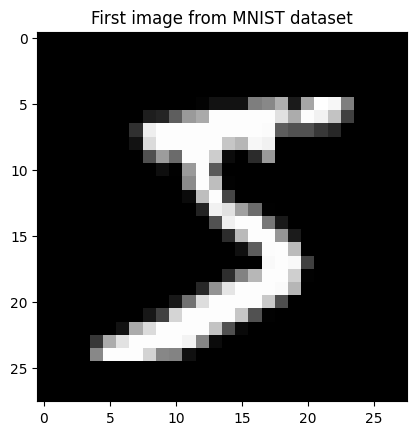

In [5]:
plt.imshow(np.array(mnist_X.loc[0]).reshape(28, 28), cmap=plt.cm.gray)
plt.title("First image from MNIST dataset")
plt.show()

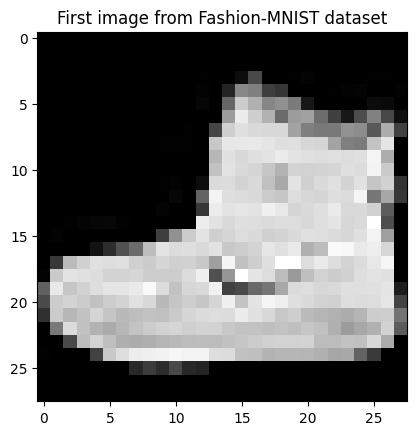

In [6]:
plt.imshow(np.array(fmnist_X.loc[0]).reshape(28, 28), cmap=plt.cm.gray)
plt.title("First image from Fashion-MNIST dataset")
plt.show()

## Part 2: Apply Dimensionality Reduction Methods

Implement and apply the following dimensionality reduction methods to both datasets:

1. t-SNE

- Apply t-SNE with at least three different perplexity values (e.g., 5, 30, 50)
- Use early exaggeration and sufficient iterations for convergence

2. UMAP

- Apply UMAP with at least three different parameter combinations:
- Vary n_neighbors (e.g., 5, 15, 30)
- Vary min_dist (e.g., 0.1, 0.5, 0.8)

3. TriMAP

- Apply TriMAP with at least two different parameter settings:
- Vary n_inliers (e.g., 10, 20)
- Vary n_outliers (e.g., 5, 10)

4. PaCMAP

- Apply PaCMAP with at least two different parameter combinations:
- Vary n_neighbors (e.g., 10, 30)
- Vary MN_ratio and FP_ratio (e.g., MN_ratio=0.5/0.8, FP_ratio=1.0/2.0)


In [7]:
def map_fmnist_labels(label):
    if label == 0:
        return "T-shirt/top"
    elif label == 1:
        return "Trouser"
    elif label == 2:
        return "Pullover"
    elif label == 3:
        return "Dress"
    elif label == 4:
        return "Coat"
    elif label == 5:
        return "Sandal"
    elif label == 6:
        return "Shirt"
    elif label == 7:
        return "Sneaker"
    elif label == 8:
        return "Bag"
    else:
        return "Ankle boot"

In [ ]:
np.random.seed(1)
indexes = np.random.randint(70000, size=1000)

mnist_X = mnist_X.loc[indexes, :]
mnist_labels = mnist.target.loc[indexes]
mnist_labels = np.array(mnist_labels).astype("int8")

fmnist_X = fmnist_X.loc[indexes, :]
fmnist_labels = fmnist.target.loc[indexes]
fmnist_labels = np.array(fmnist_labels).astype("int8")
fmnist_labels = np.array(list(map(map_fmnist_labels, fmnist_labels)))

In [10]:
from sklearn.neighbors import NearestNeighbors


def cf_metric(X_original, Y_embedded, nmax=100):
    nbrs_orig = NearestNeighbors(n_neighbors=nmax).fit(X_original)
    _, orig_indices = nbrs_orig.kneighbors(X_original)  # Neighbors in original space

    nbrs_proj = NearestNeighbors(n_neighbors=nmax).fit(Y_embedded)
    _, proj_indices = nbrs_proj.kneighbors(Y_embedded)  # Neighbors in projected space

    cf = 0.0
    for m in range(1, nmax + 1):
        matches = 0
        for i in range(len(X_original)):
            # Compare top m neighbors in original vs projected space
            common = np.intersect1d(
                orig_indices[i, 1 : m + 1], proj_indices[i, 1 : m + 1]
            )
            matches += len(common)
        cf += matches / (len(X_original) * m)

    return cf / nmax

In [11]:
methods = {
    "t-SNE": {
        "model": TSNE,
        "params": [
            {"perplexity": 5, "early_exaggeration": 12, "max_iter": 1000},
            {"perplexity": 15, "early_exaggeration": 10, "max_iter": 1000},
            {"perplexity": 30, "early_exaggeration": 7, "max_iter": 1000},
        ],
    },
    "UMAP": {
        "model": umap.UMAP,
        "params": [
            {"n_neighbors": 5, "min_dist": 0.1},
            {"n_neighbors": 15, "min_dist": 0.5},
            {"n_neighbors": 30, "min_dist": 0.8},
        ],
    },
    "TriMAP": {
        "model": trimap.TRIMAP,
        "params": [
            {"n_inliers": 10, "n_outliers": 5},
            {"n_inliers": 20, "n_outliers": 10},
        ],
    },
}

In [42]:
results = {}

for method, config in methods.items():
    results[method] = []
    for param_set in config["params"]:
        mnist_model = config["model"](**param_set)
        fmnist_model = config["model"](**param_set)

        mnist_embedding = mnist_model.fit_transform(mnist_X)
        fmnist_embedding = fmnist_model.fit_transform(fmnist_X)

        mnist_cf = cf_metric(mnist_X, mnist_embedding)
        fmnist_cf = cf_metric(fmnist_X, fmnist_embedding)

        results[method].append(
            {
                "mnist_embedding": mnist_embedding,
                "f-mnist": fmnist_embedding,
                "params": param_set,
                "mnist_class_fidelity": round(mnist_cf, 2),
                "fmnist_class_fidelity": round(fmnist_cf, 2),
            }
        )

/Users/nicolas/studia/I_sem/wdzd/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nicolas/studia/I_sem/wdzd/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nicolas/studia/I_sem/wdzd/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nicolas/studia/I_sem/wdzd/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nicolas/studia/I_sem/wdzd/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

## Part 3: Visualization and Qualitative Analysis

For each method and parameter setting:

1. Create 2D scatter plots of the reduced datasets

- Color points by their class labels
- Use consistent colormaps across visualizations
- Include a legend identifying each class

2. Visually assess:

- How well classes are separated
- Whether similar classes are positioned near each other
- The presence of any meaningful global structure

3. Create an enhanced visualization for the best performing configuration of each method:

- Replace points with miniature versions of the actual digit/fashion item images
- Limit to a representative subset (e.g., 500-1000 points) for clarity


In [15]:
hue_order = np.array(mnist.target.value_counts().index.sort_values()).astype("int8")
hue_order

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

In [16]:
fmnist_mapped_labels = list(map(map_fmnist_labels, hue_order))
fmnist_mapped_labels

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

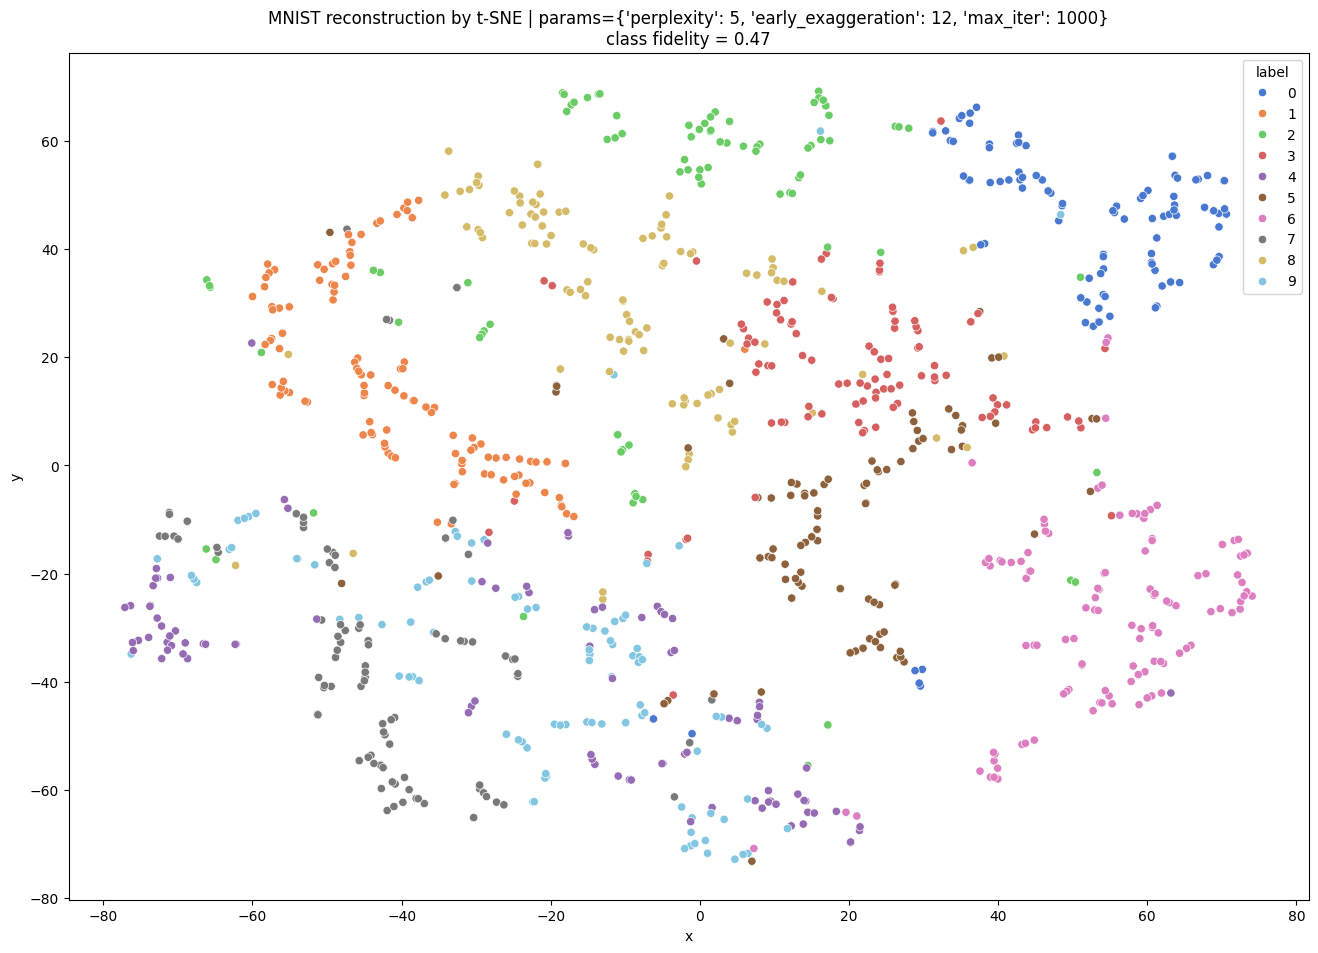

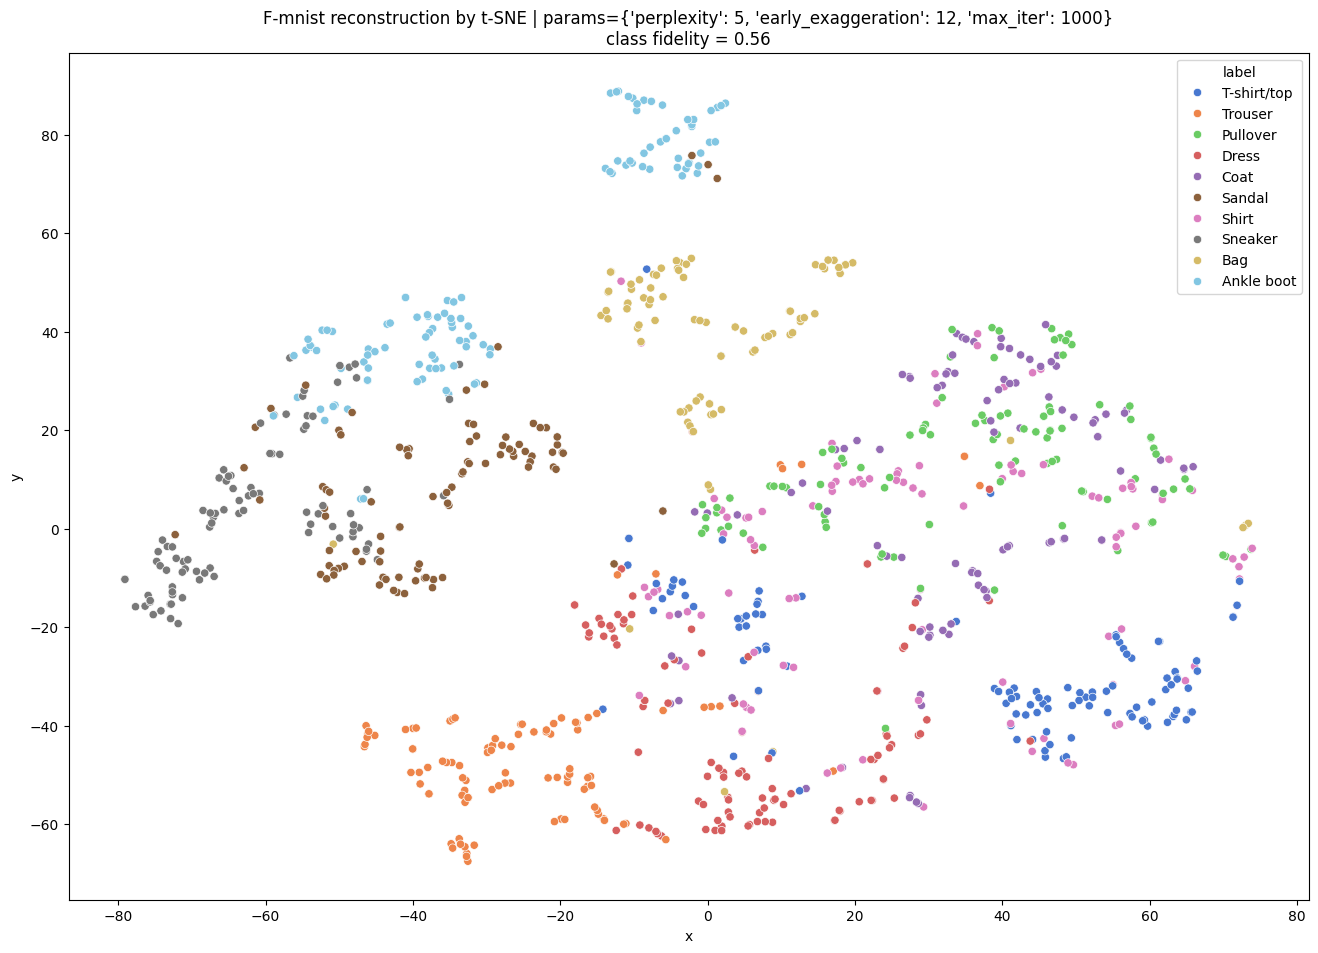

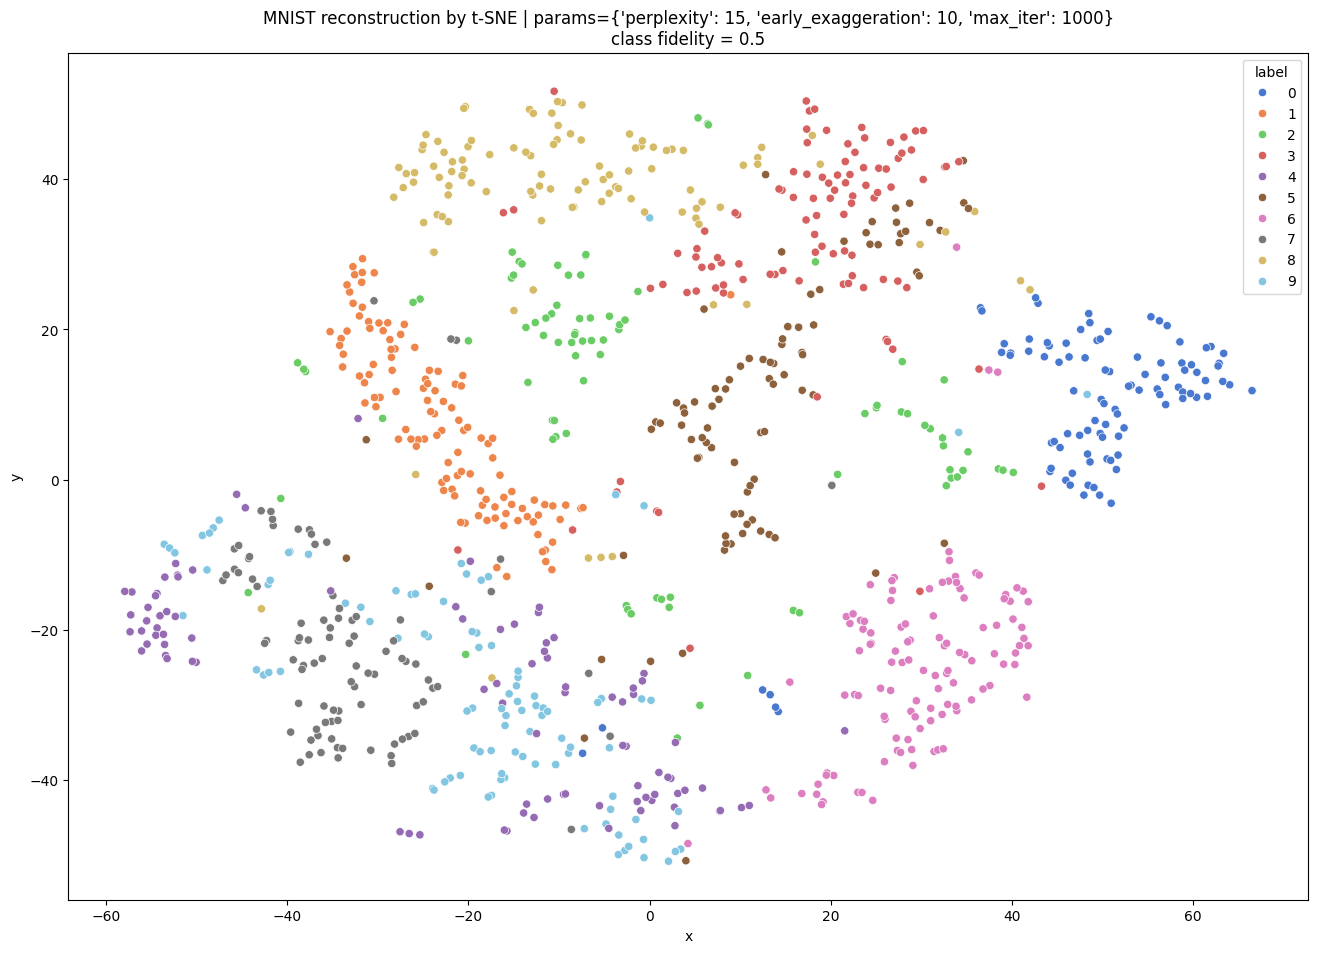

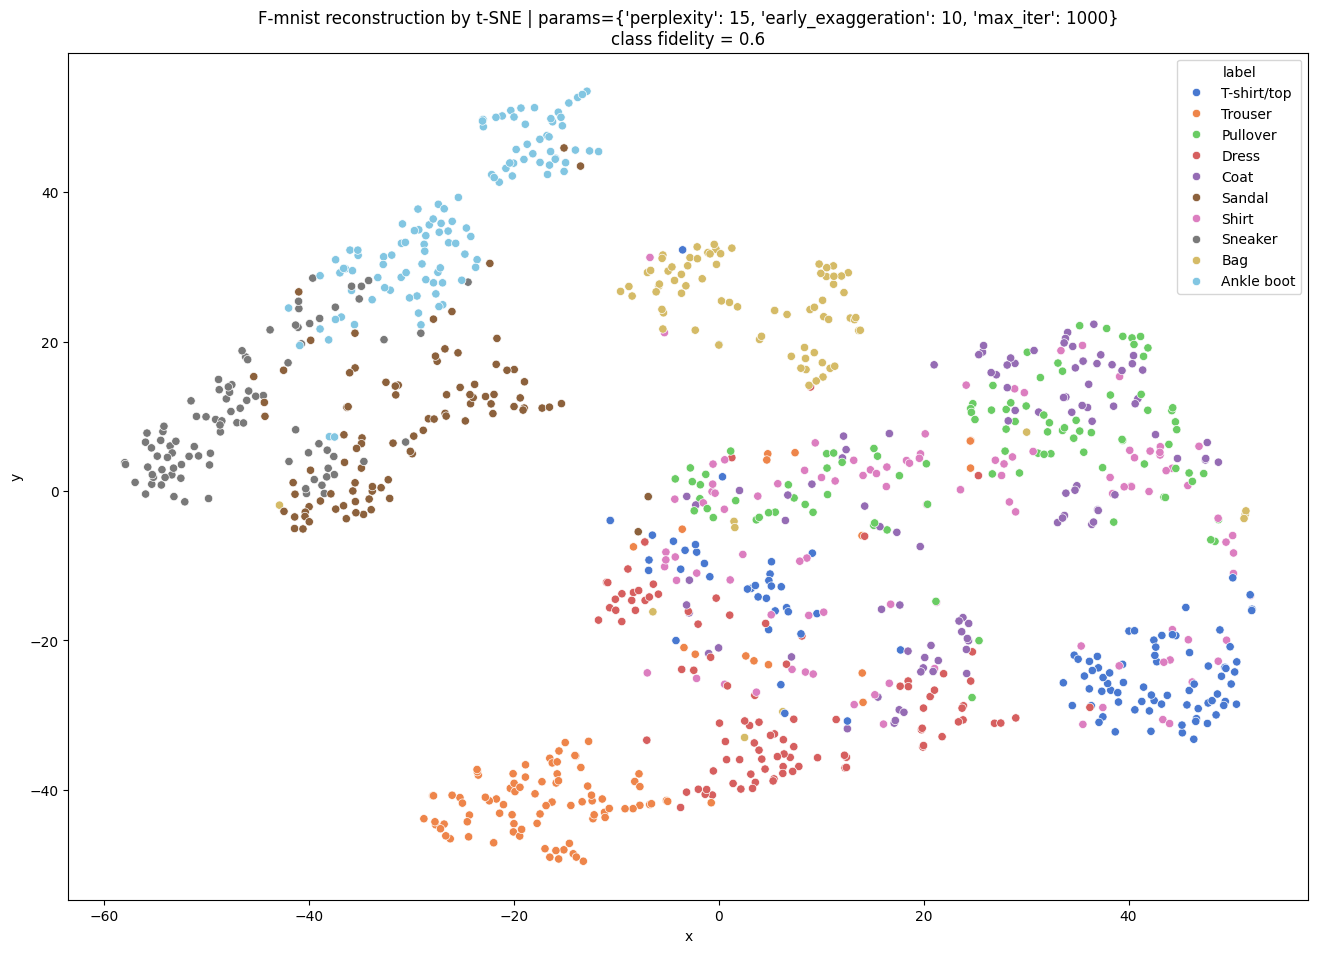

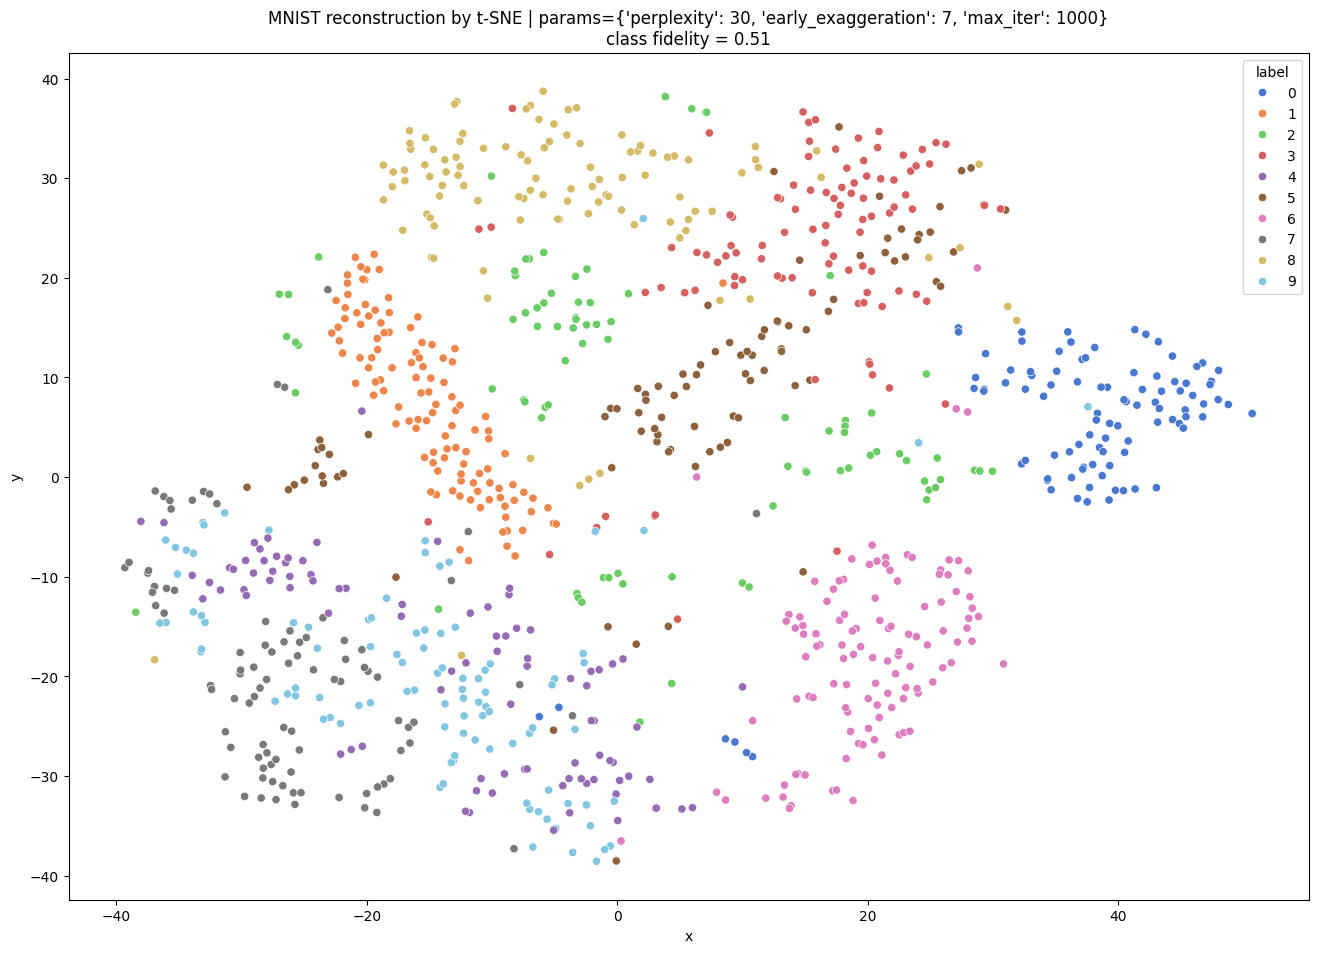

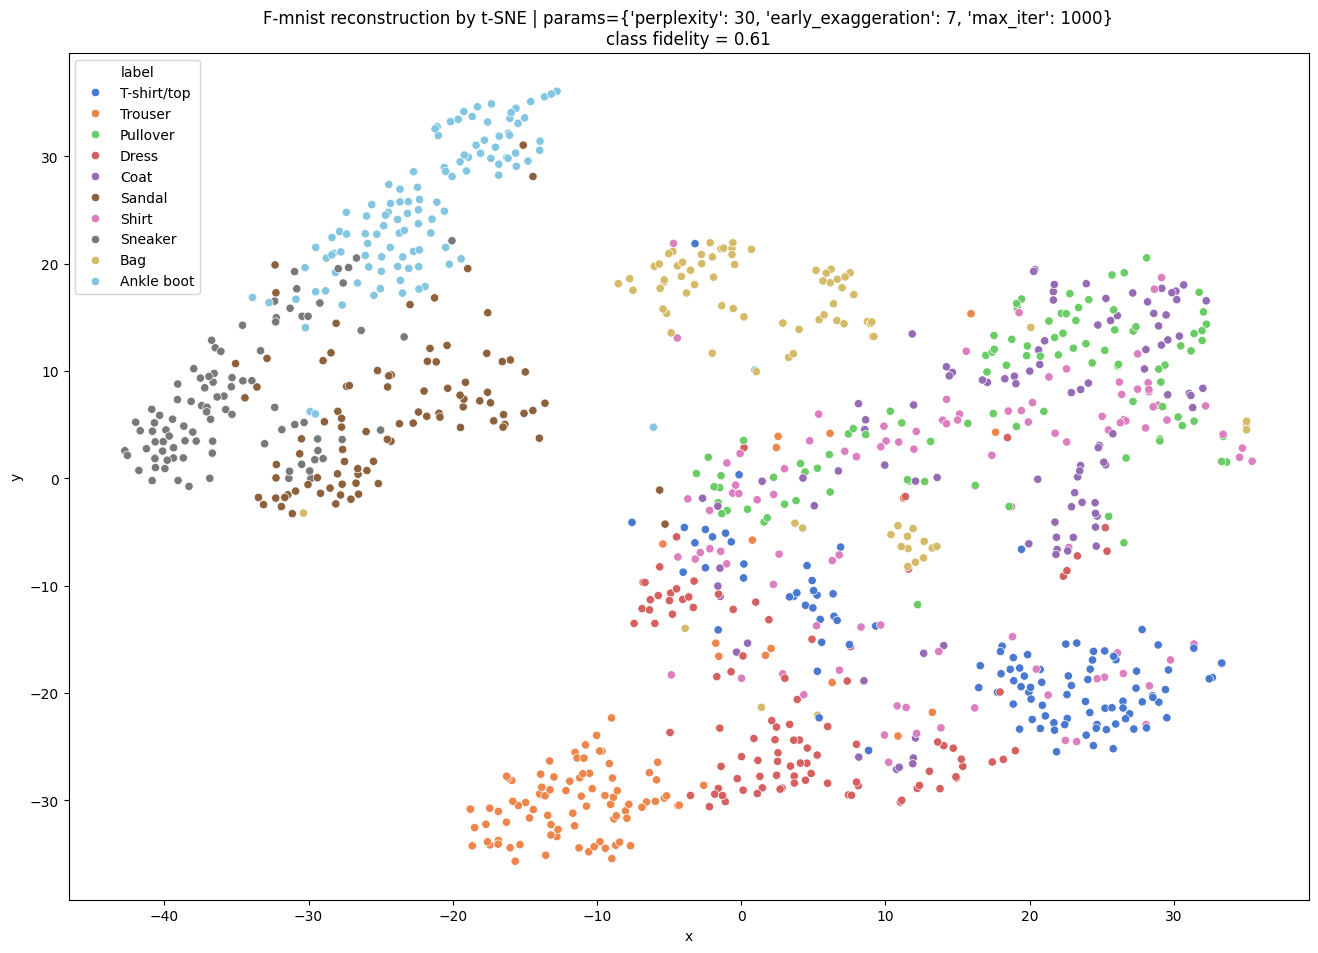

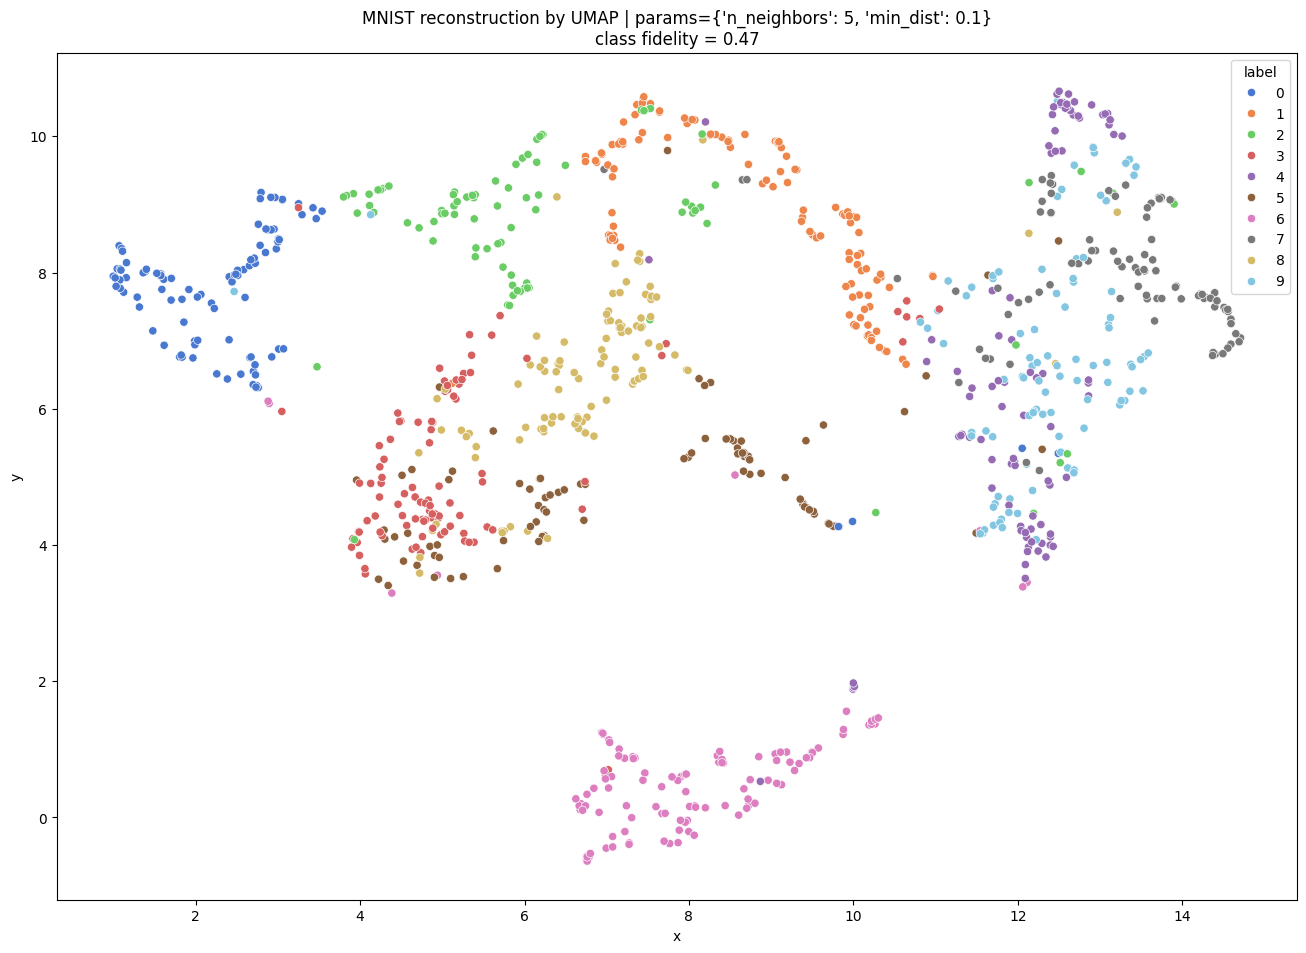

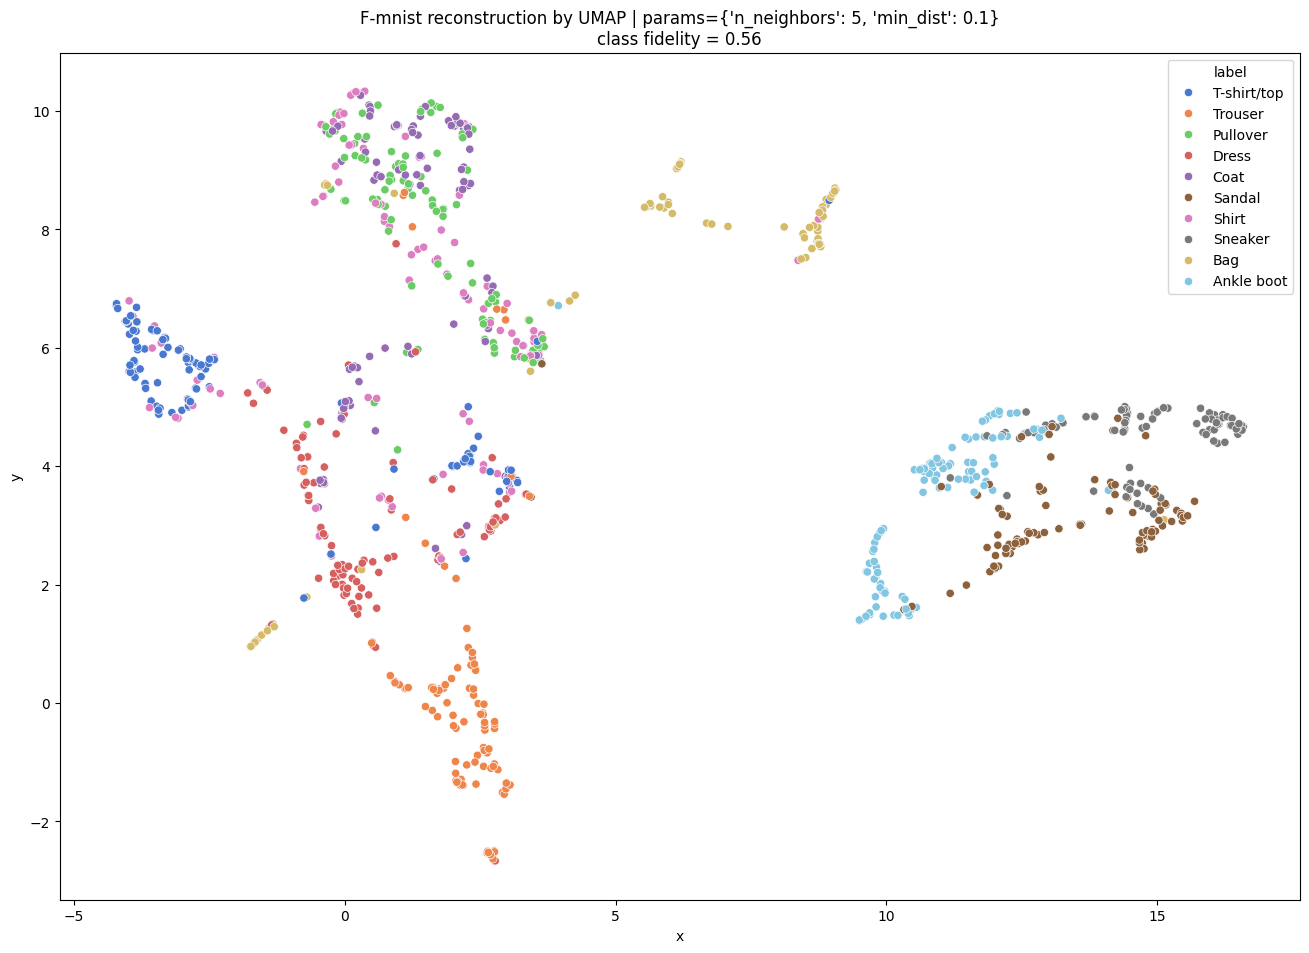

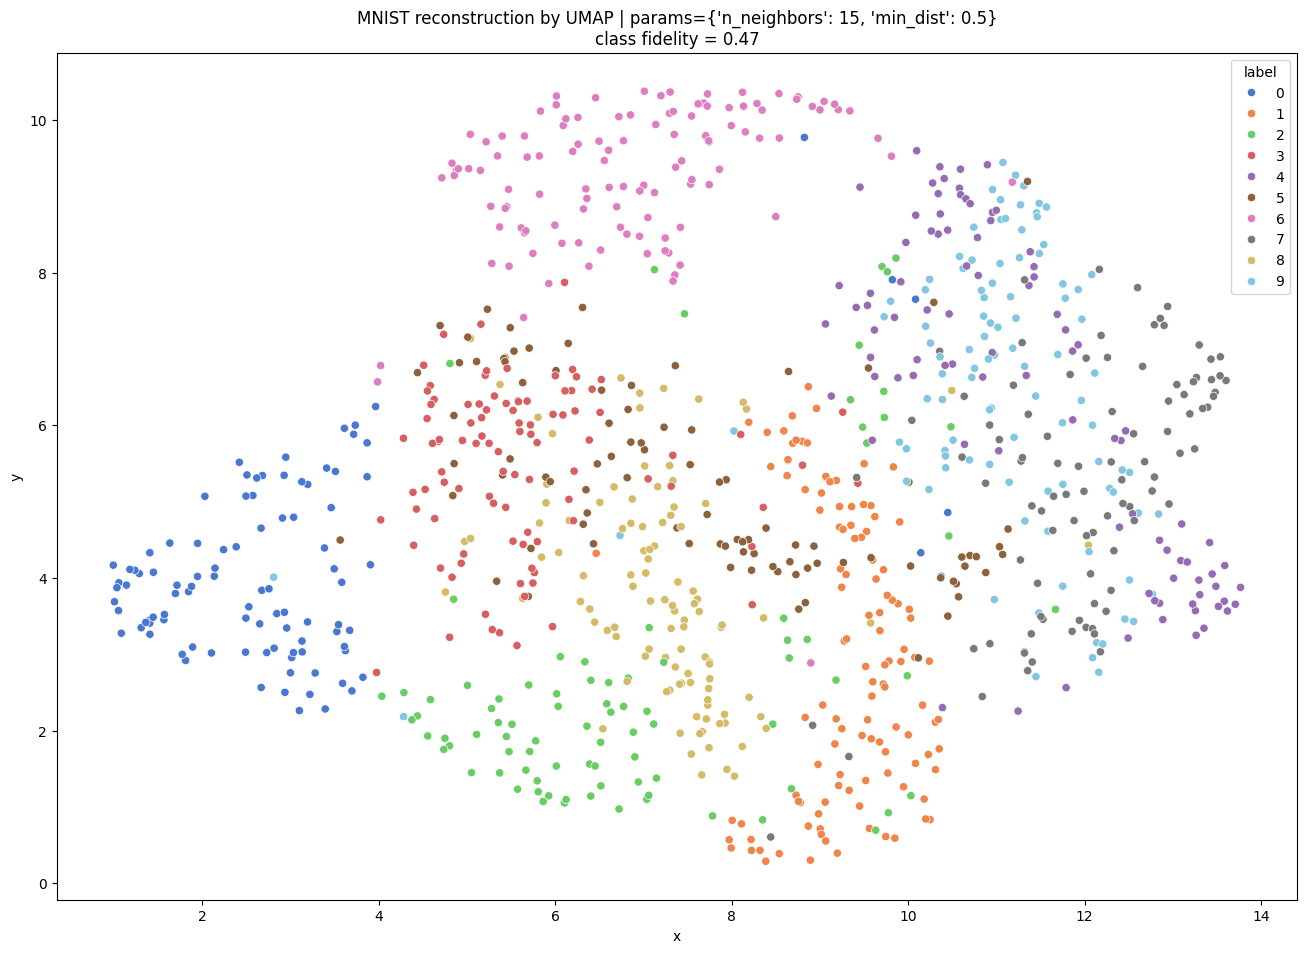

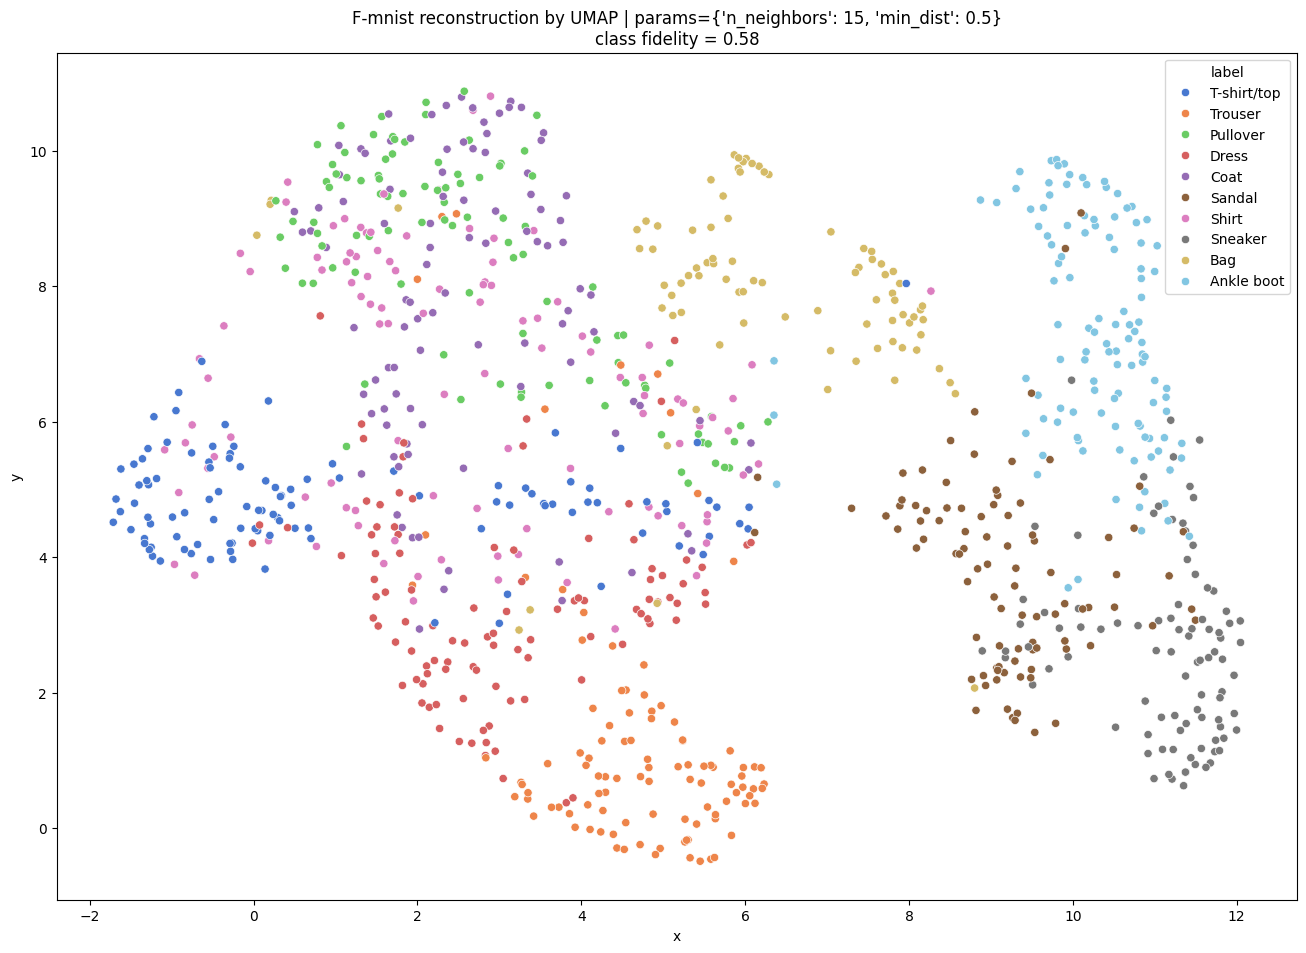

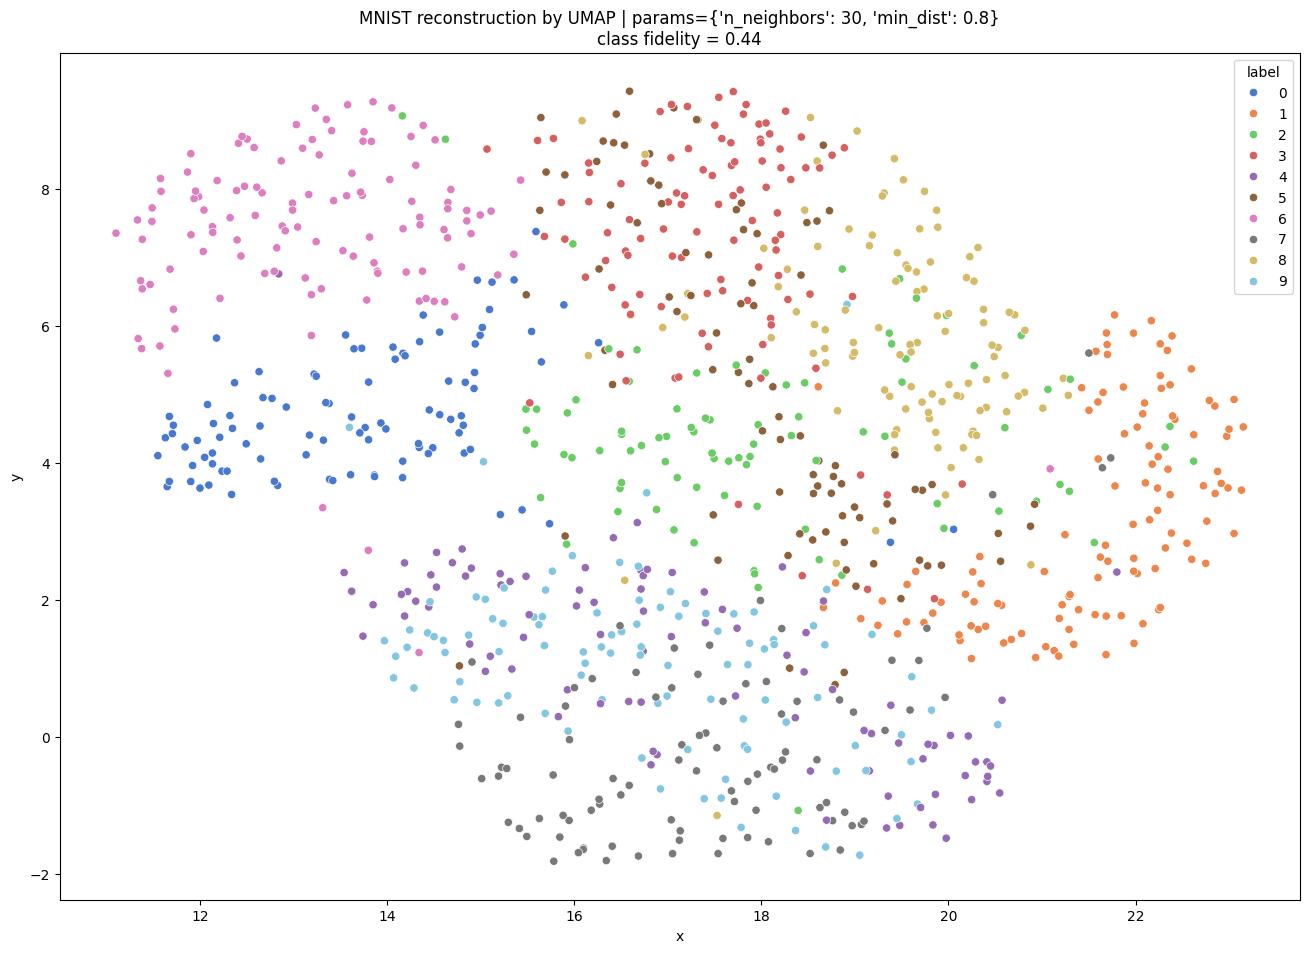

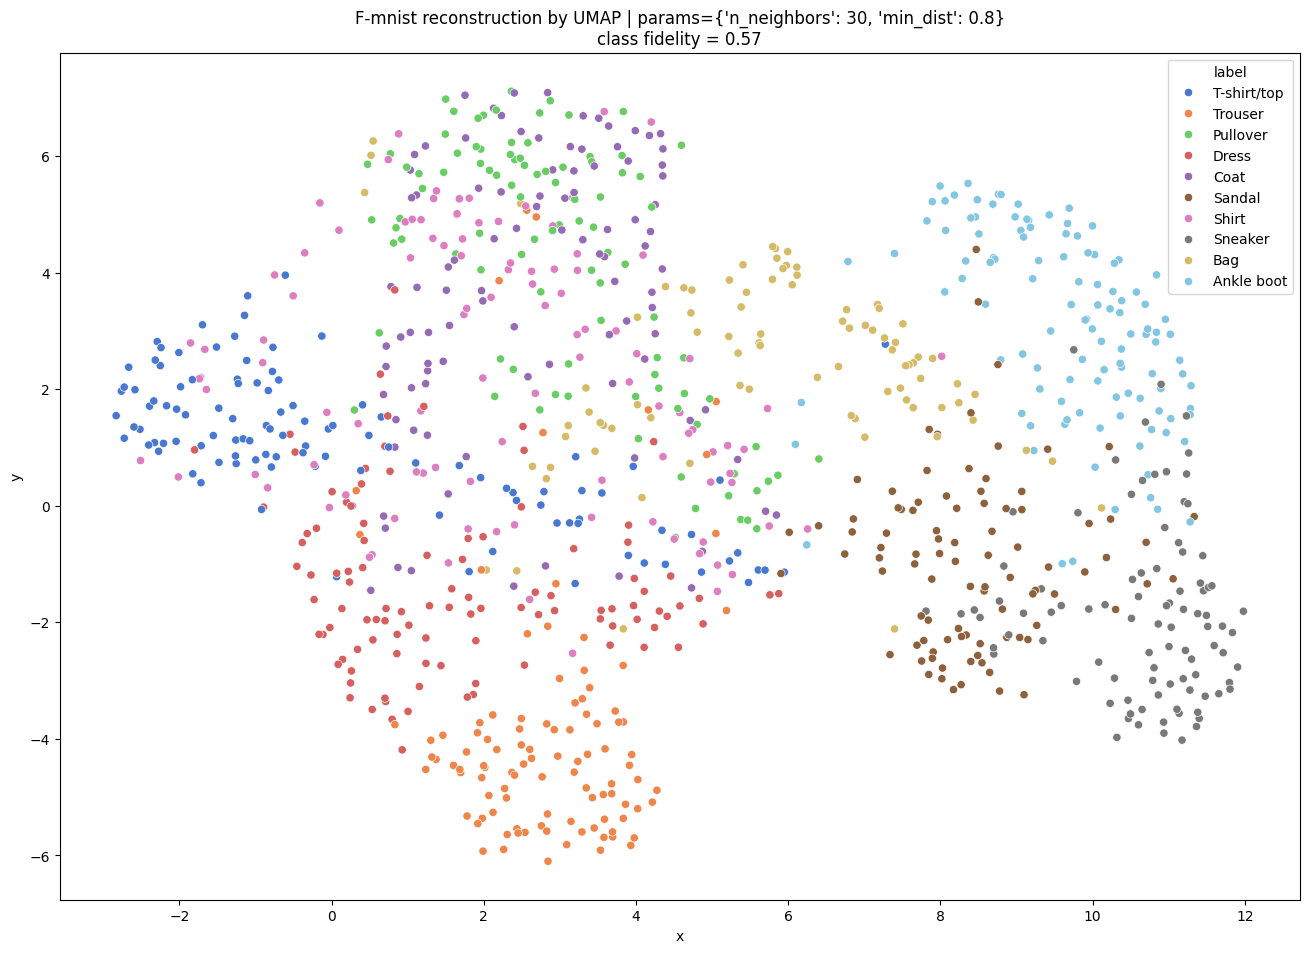

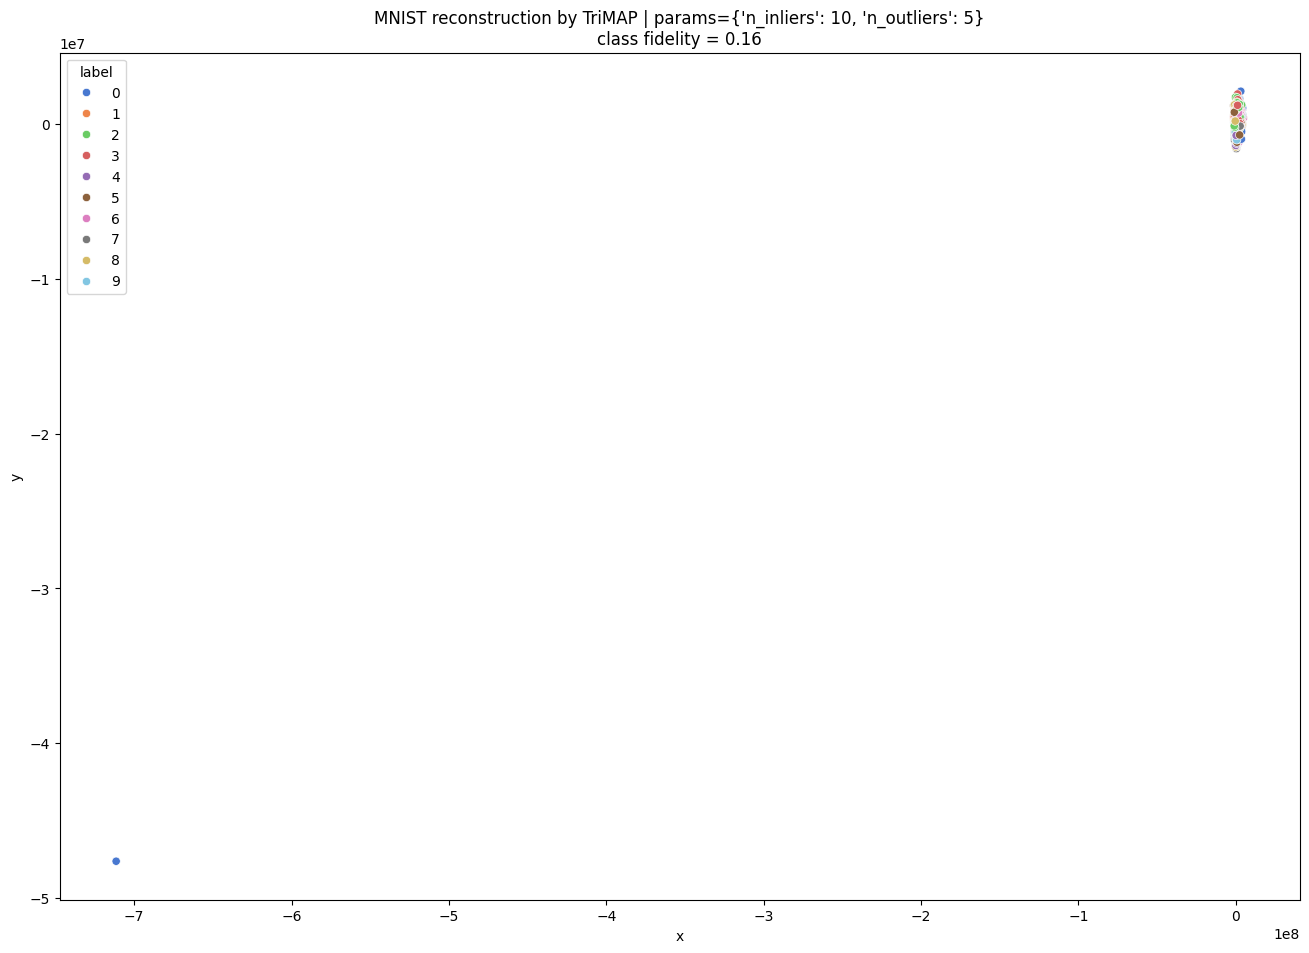

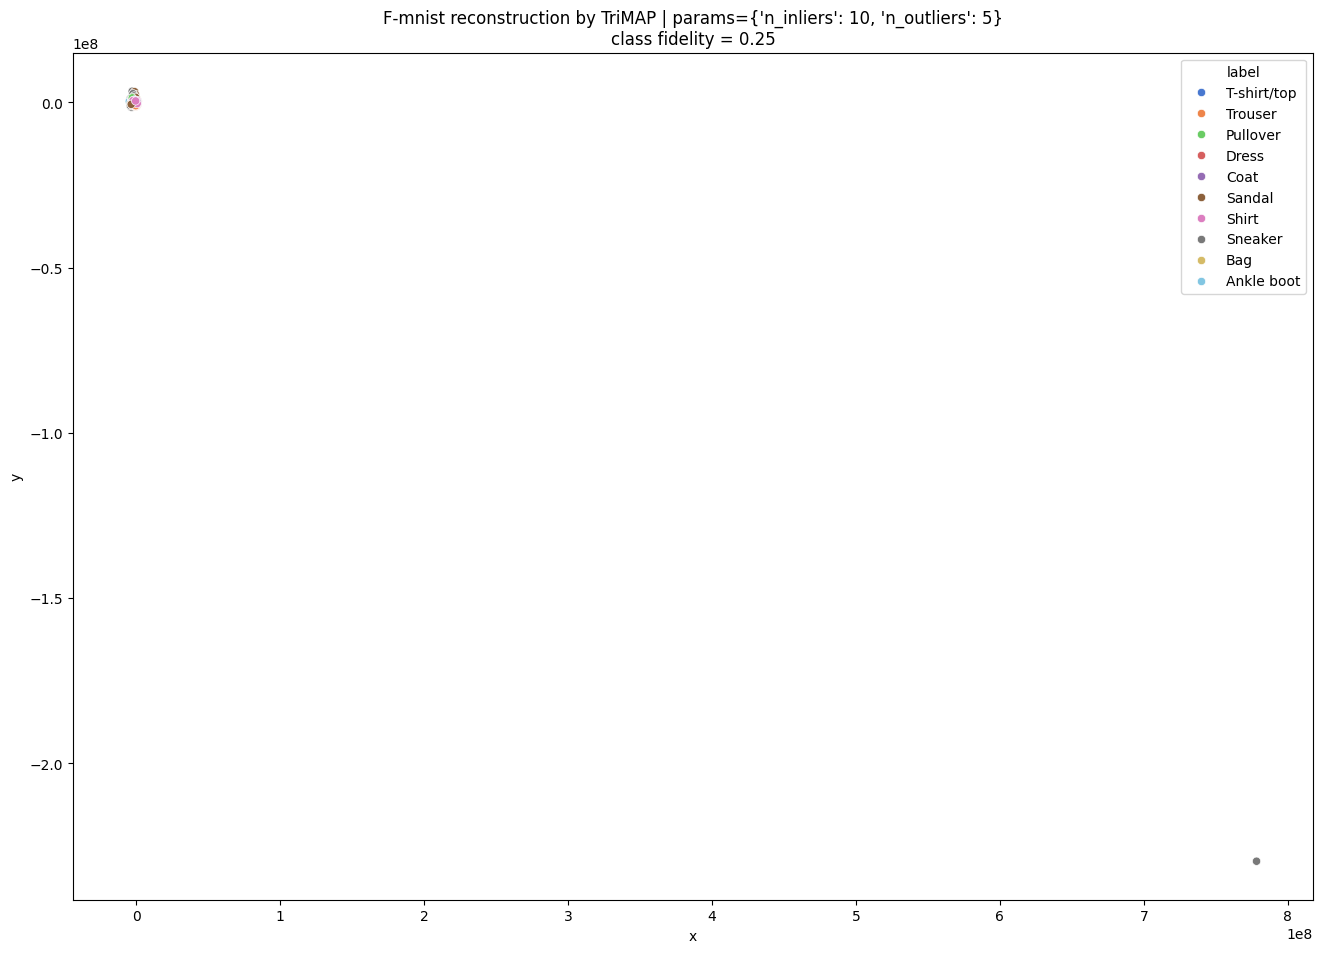

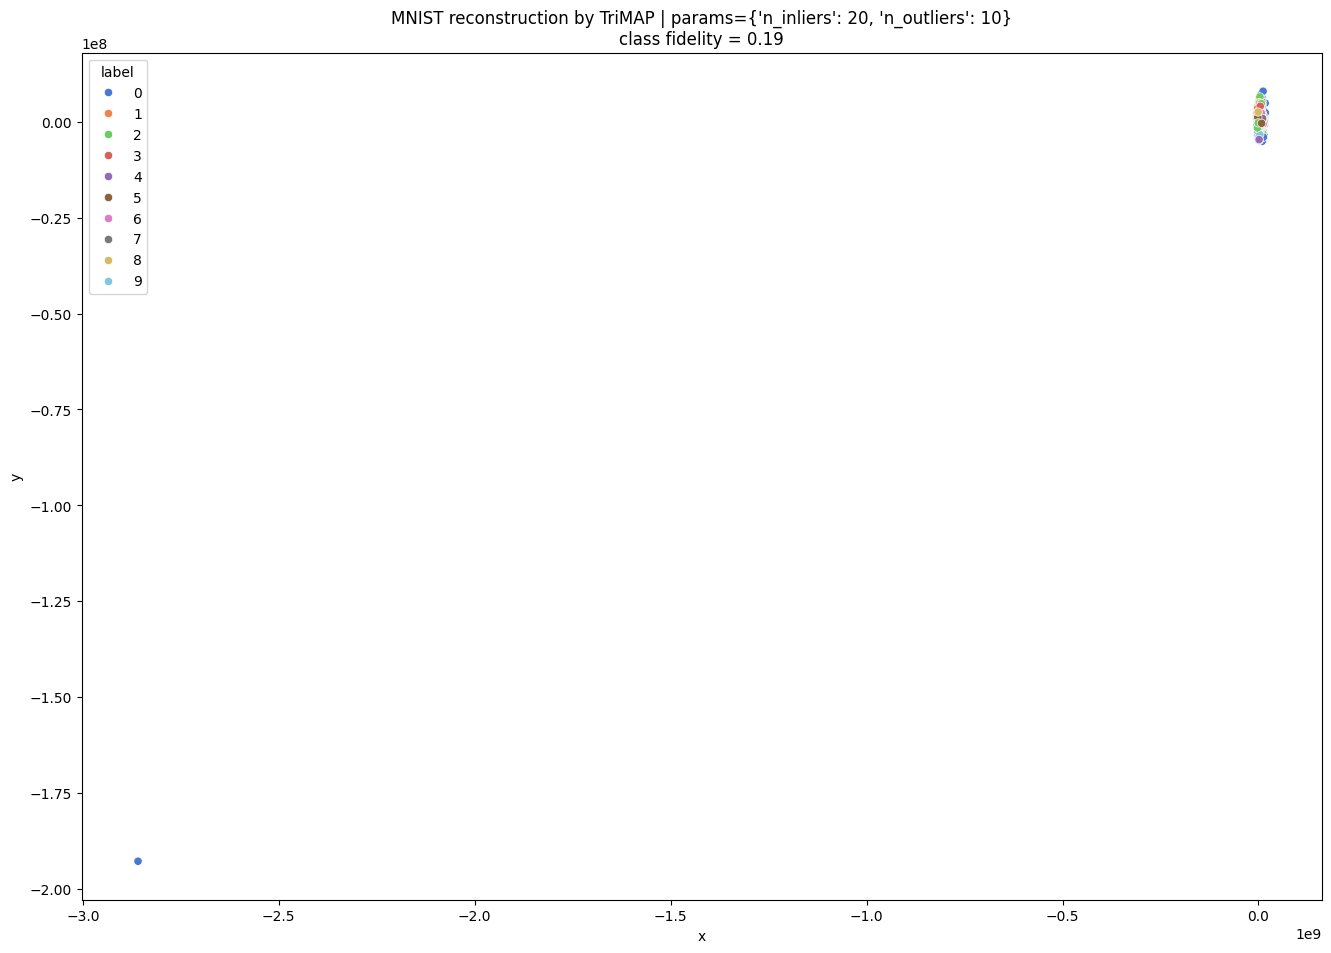

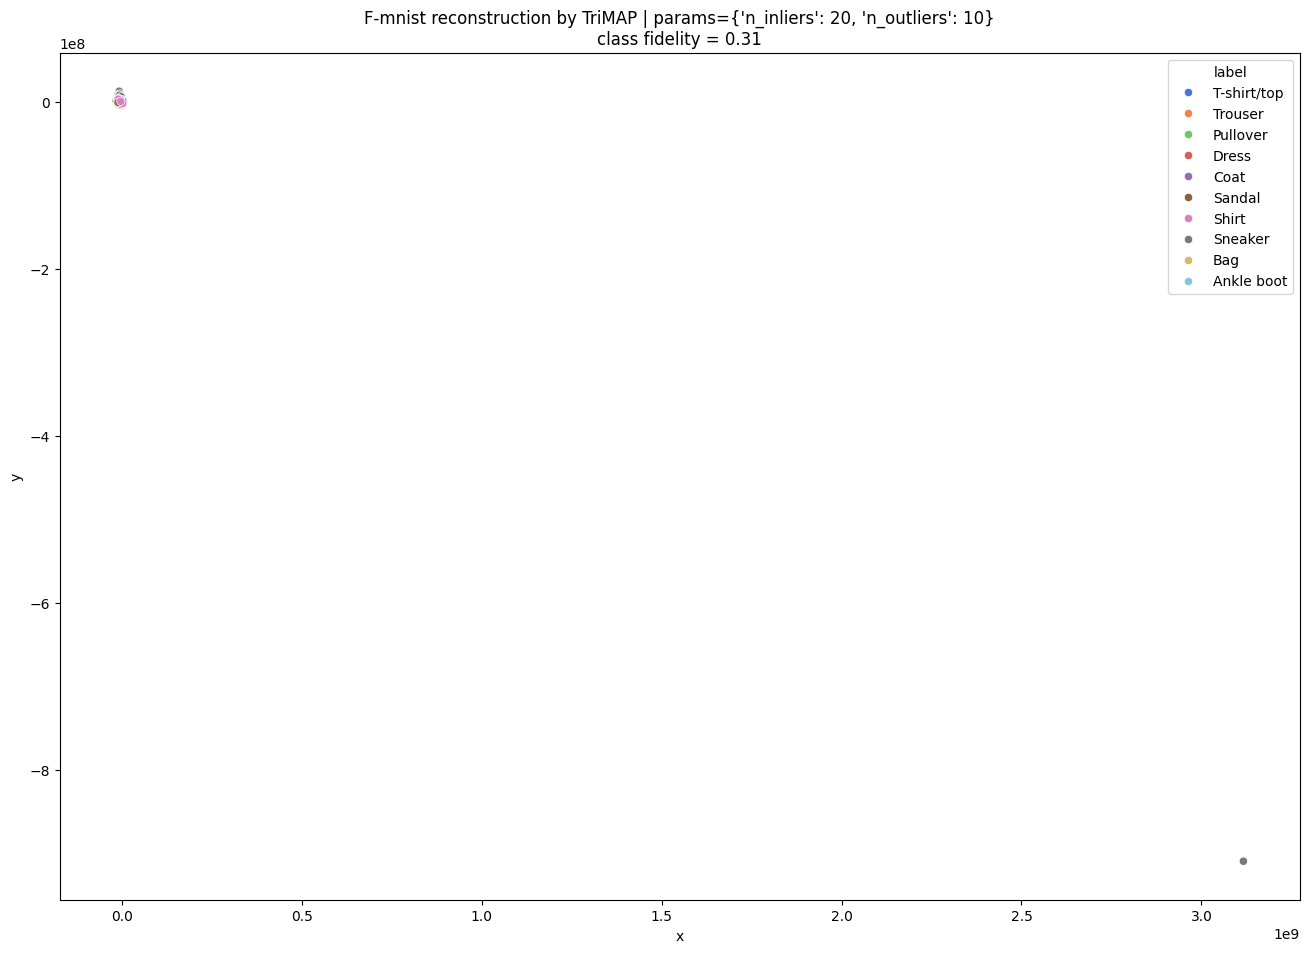

In [44]:
import seaborn as sns

for method in results:
    for model in results[method]:
        mnist = pd.DataFrame(model["mnist_embedding"], columns=["x", "y"])
        mnist["label"] = mnist_labels

        fmnist = pd.DataFrame(model["f-mnist"], columns=["x", "y"])
        fmnist["label"] = fmnist_labels

        mnist_cf = model["mnist_class_fidelity"]
        fmnist_cf = model["fmnist_class_fidelity"]

        plt.figure(figsize=(16, 11))
        sns.scatterplot(
            data=mnist, x="x", y="y", hue="label", hue_order=hue_order, palette="muted"
        )
        plt.title(
            f"MNIST reconstruction by {method} | params={model['params']}\nclass fidelity = {mnist_cf}"
        )
        plt.show()

        plt.figure(figsize=(16, 11))
        sns.scatterplot(
            data=fmnist,
            x="x",
            y="y",
            hue="label",
            hue_order=fmnist_mapped_labels,
            palette="muted",
        )
        plt.title(
            f"F-mnist reconstruction by {method} | params={model['params']}\nclass fidelity = {fmnist_cf}"
        )
        plt.show()

In [45]:
print("Best parameters for t-SNE: {perplexity=30, early_exaggeration=7, max_iter=1000}")
print("Best parameters for UMAP: {n_neighbors=15, min_dist=0.5}")
print("Best parameters for TriMAP: {n_inliers=20, n_outliers=10}")

Best parameters for t-SNE: {perplexity=30, early_exaggeration=7, max_iter=1000}
Best parameters for UMAP: {n_neighbors=15, min_dist=0.5}
Best parameters for TriMAP: {n_inliers=20, n_outliers=10}


In [46]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image


def create_meta_visualizations(embeddings, original_X, method, params):
    embeddings = np.array([[embedding[0], embedding[1]] for embedding in embeddings])

    fig, ax = plt.subplots(figsize=(10, 10))

    for (x, y), (idx, img) in zip(embeddings, original_X.iterrows()):
        img = np.array(img).reshape(28, 28)
        im = OffsetImage(img, zoom=0.5)
        ab = AnnotationBbox(im, (x, y), frameon=False)
        ax.add_artist(ab)

    ax.set_xlim(np.min(embeddings[:, 0]) - 1, np.max(embeddings[:, 0]) + 1)
    ax.set_ylim(np.min(embeddings[:, 1]) - 1, np.max(embeddings[:, 1]) + 1)
    ax.set_title(f"Meta-Visualization ({method} | {params})")
    plt.show()

In [47]:
mnist_X = mnist_X.reset_index(drop=True)
fmnist_X = fmnist_X.reset_index(drop=True)

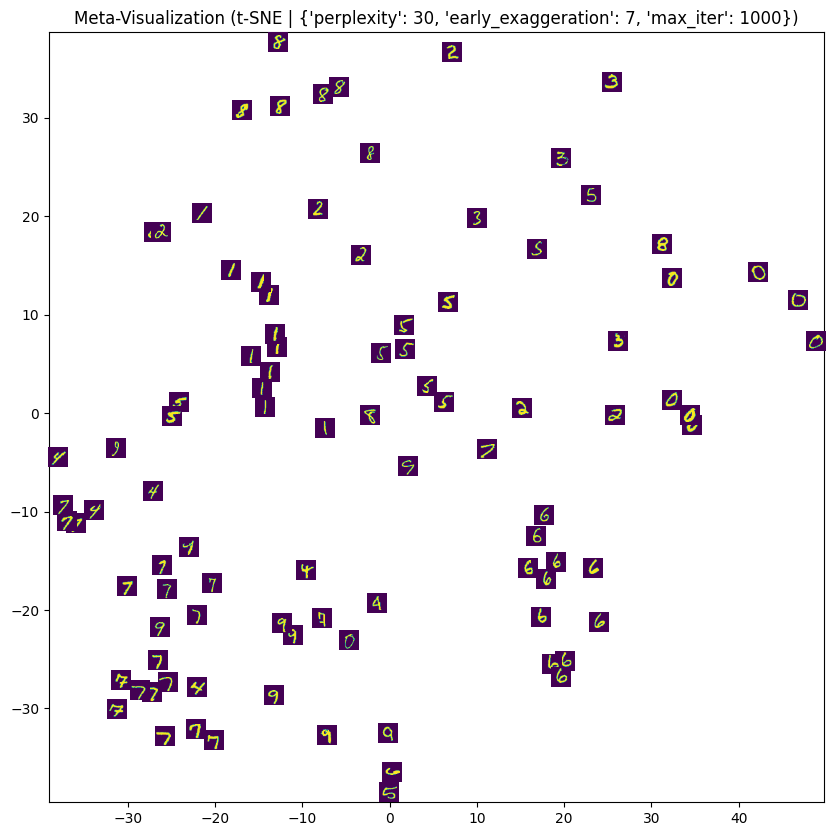

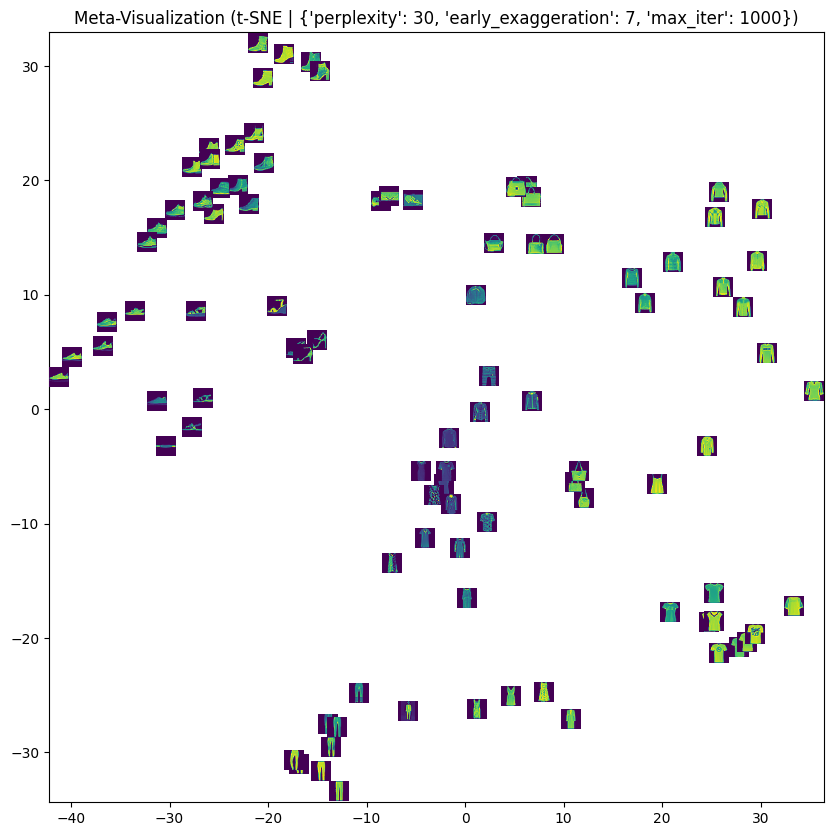

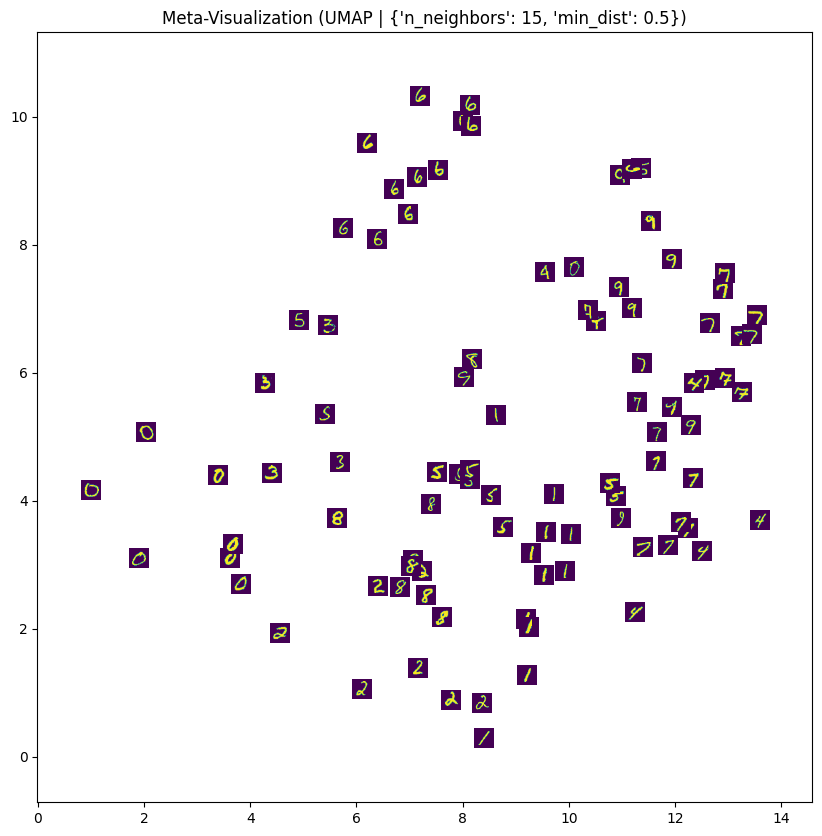

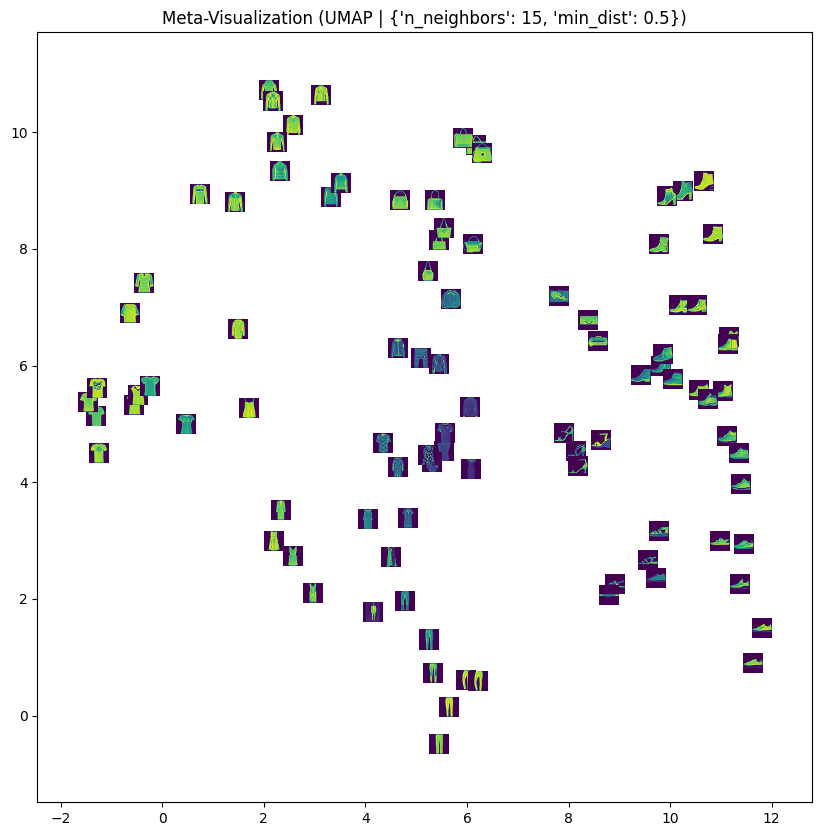

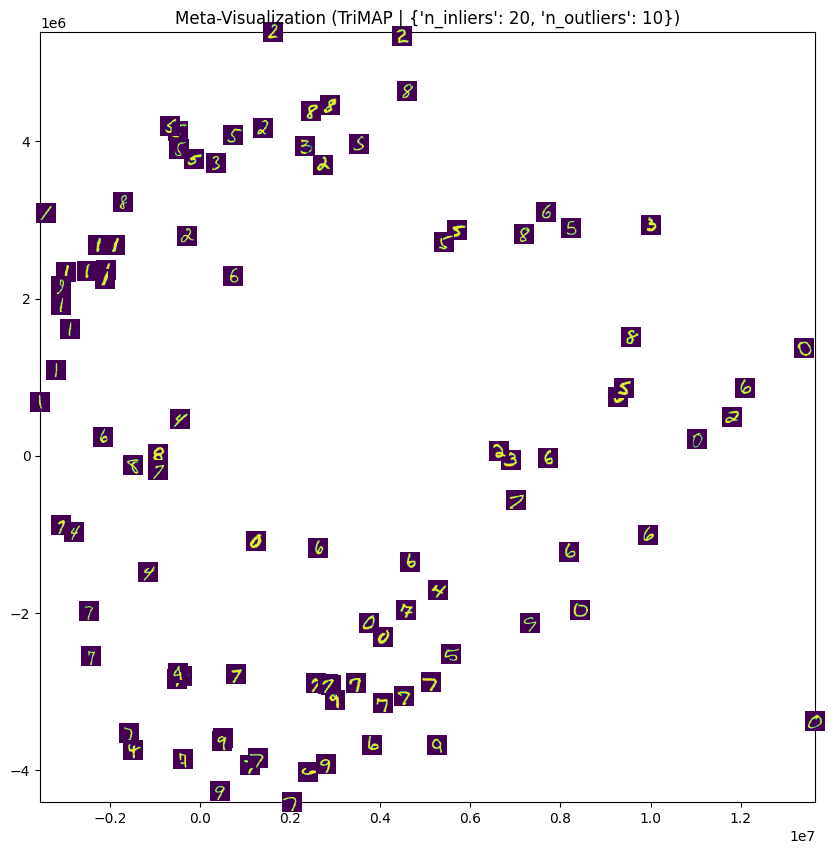

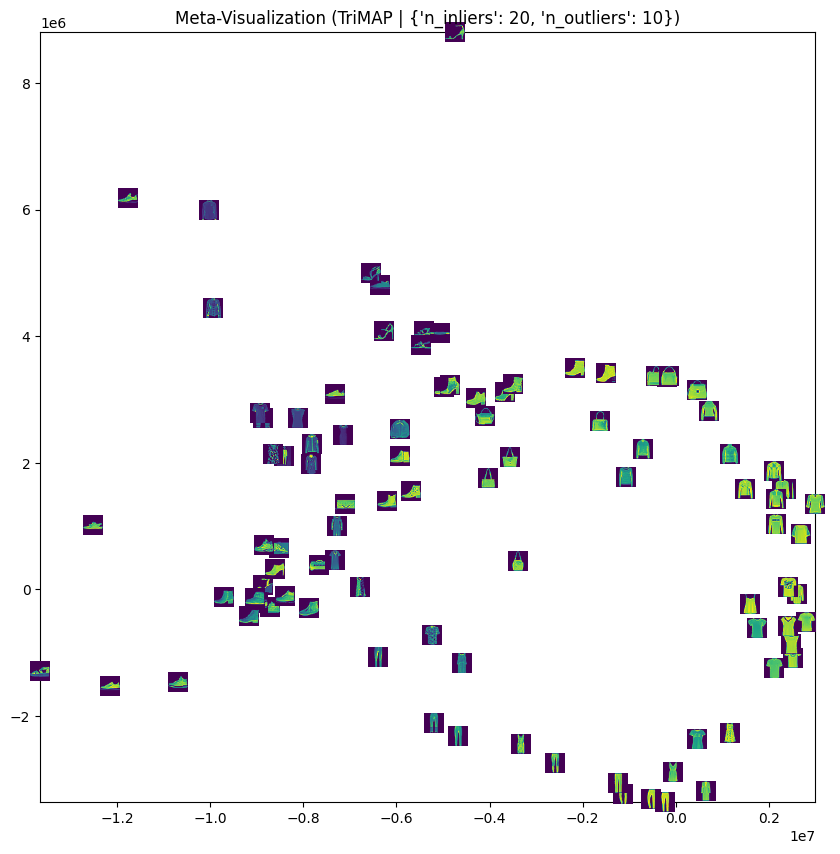

In [48]:
indexes = np.random.randint(1000, size=100)

best_models_idx = [2, 1, 1]

for method, idx in zip(results, best_models_idx):
    create_meta_visualizations(
        embeddings=results[method][idx]["mnist_embedding"][indexes],
        original_X=mnist_X.loc[indexes],
        method=method,
        params=results[method][idx]["params"],
    )
    create_meta_visualizations(
        embeddings=results[method][idx]["f-mnist"][indexes],
        original_X=fmnist_X.loc[indexes],
        method=method,
        params=results[method][idx]["params"],
    )

## Part 4: Quantitative Evaluation

1. Use the Nearest Neighbor Class Fidelity (cf) metric.
2. For each method and parameter setting, calculate:

- The cf metric
- Trustworthiness
- Additional metrics from the provided laboratory script

3. Create comparison tables and visualizations of these metrics


In [49]:
import numba
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

from scipy.spatial.distance import squareform, pdist
from sklearn.model_selection import train_test_split

markers = ["x", "o", "s", "*", "^", ".", "X"]
colors = ["red", "blue", "green", "brown", "orange", "cyan", "grey", "purple"]


@numba.jit(nopython=True)
def knngain(d_hd, d_ld, labels):
    # Number of data points
    N = d_hd.shape[0]
    N_1 = N - 1
    k_hd = np.zeros(shape=N_1, dtype=np.int64)
    k_ld = np.zeros(shape=N_1, dtype=np.int64)
    # For each data point
    for i in range(N):
        c_i = labels[i]
        di_hd = d_hd[i, :].argsort(kind="mergesort")
        di_ld = d_ld[i, :].argsort(kind="mergesort")
        # Making sure that i is first in di_hd and di_ld
        for arr in [di_hd, di_ld]:
            for idj, j in enumerate(arr):
                if j == i:
                    idi = idj
                    break
            if idi != 0:
                arr[idi] = arr[0]
            arr = arr[1:]
        for k in range(N_1):
            if c_i == labels[di_hd[k]]:
                k_hd[k] += 1
            if c_i == labels[di_ld[k]]:
                k_ld[k] += 1
    # Computing the KNN gain
    gn = (k_ld.cumsum() - k_hd.cumsum()).astype(np.float64) / (
        (1.0 + np.arange(N_1)) * N
    )
    # Returning the KNN gain and its AUC
    return gn, eval_auc(gn)


@numba.jit(nopython=True)
def eval_auc(arr):
    i_all_k = 1.0 / (np.arange(arr.size) + 1.0)
    return np.float64(arr.dot(i_all_k)) / (i_all_k.sum())


@numba.jit(nopython=True)
def eval_rnx(Q):
    N_1 = Q.shape[0]
    N = N_1 + 1
    # Computing Q_NX
    qnxk = np.empty(shape=N_1, dtype=np.float64)
    acc_q = 0.0
    for K in range(N_1):
        acc_q += Q[K, K] + np.sum(Q[K, :K]) + np.sum(Q[:K, K])
        qnxk[K] = acc_q / ((K + 1) * N)
    # Computing R_NX
    arr_K = np.arange(N_1)[1:].astype(np.float64)
    rnxk = (N_1 * qnxk[: N_1 - 1] - arr_K) / (N_1 - arr_K)
    # Returning
    return rnxk


def eval_dr_quality(d_hd, d_ld):
    # Computing the co-ranking matrix of the embedding, and the R_{NX}(K) curve.
    rnxk = eval_rnx(Q=coranking(d_hd=d_hd, d_ld=d_ld))
    # Computing the AUC, and returning.
    return rnxk, eval_auc(rnxk)


def coranking(d_hd, d_ld):
    # Computing the permutations to sort the rows of the distance matrices in HDS and LDS.
    perm_hd = d_hd.argsort(axis=-1, kind="mergesort")
    perm_ld = d_ld.argsort(axis=-1, kind="mergesort")

    N = d_hd.shape[0]
    i = np.arange(N, dtype=np.int64)
    # Computing the ranks in the LDS
    R = np.empty(shape=(N, N), dtype=np.int64)
    for j in range(N):
        R[perm_ld[j, i], j] = i
    # Computing the co-ranking matrix
    Q = np.zeros(shape=(N, N), dtype=np.int64)
    for j in range(N):
        Q[i, R[perm_hd[j, i], j]] += 1
    # Returning
    return Q[1:, 1:]


def viz_qa(
    Ly,
    ymin=None,
    ymax=None,
    Lmarkers=None,
    Lcols=None,
    Lleg=None,
    Lls=None,
    Lmedw=None,
    Lsdots=None,
    lw=2,
    markevery=0.1,
    tit="",
    folder_name="",
    xlabel="",
    ylabel="",
    alpha_plot=0.9,
    alpha_leg=0.8,
    stit=25,
    sax=20,
    sleg=15,
    zleg=1,
    loc_leg="best",
    ncol_leg=1,
    lMticks=10,
    lmticks=5,
    wMticks=2,
    wmticks=1,
    nyMticks=11,
    mymticks=4,
    grid=True,
    grid_ls="solid",
    grid_col="lightgrey",
    grid_alpha=0.7,
    xlog=True,
):
    # Number of curves
    nc = len(Ly)
    # Checking the parameters
    if ymin is None:
        ymin = np.min(np.asarray([arr.min() for arr in Ly]))
    if ymax is None:
        ymax = np.max(np.asarray([arr.max() for arr in Ly]))
    if Lmarkers is None:
        Lmarkers = ["x"] * nc
    if Lcols is None:
        Lcols = ["blue"] * nc
    if Lleg is None:
        Lleg = [None] * nc
        add_leg = False
    else:
        add_leg = True
    if Lls is None:
        Lls = ["solid"] * nc
    if Lmedw is None:
        Lmedw = [float(lw) / 2.0] * nc
    if Lsdots is None:
        Lsdots = [12] * nc

    # Setting the limits of the y-axis
    y_lim = [ymin, ymax]

    # Defining the ticks on the y-axis
    yMticks = np.linspace(
        start=ymin, stop=ymax, num=nyMticks, endpoint=True, retstep=False
    )
    ymticks = np.linspace(
        start=ymin,
        stop=ymax,
        num=1 + mymticks * (nyMticks - 1),
        endpoint=True,
        retstep=False,
    )
    yMticksLab = [int(round(v * 100.0)) / 100.0 for v in yMticks]

    # Initial values for xmin and xmax
    xmin, xmax = 1, -np.inf

    fig = plt.figure(figsize=(16, 12))
    ax = fig.add_subplot(111)
    if xlog:
        fplot = ax.semilogx
    else:
        fplot = ax.plot

    # Plotting the data
    for id, y in enumerate(Ly):
        x = np.arange(start=1, step=1, stop=y.size + 0.5, dtype=np.int64)
        xmax = max(xmax, x[-1])
        fplot(
            x,
            y,
            label=Lleg[id],
            alpha=alpha_plot,
            color=Lcols[id],
            linestyle=Lls[id],
            lw=lw,
            marker=Lmarkers[id],
            markeredgecolor=Lcols[id],
            markeredgewidth=Lmedw[id],
            markersize=Lsdots[id],
            dash_capstyle="round",
            solid_capstyle="round",
            dash_joinstyle="round",
            solid_joinstyle="round",
            markerfacecolor=Lcols[id],
            markevery=markevery,
        )

    # Setting the limits of the axes
    ax.set_xlim([xmin, xmax])
    ax.set_ylim(y_lim)

    # Setting the major and minor ticks on the y-axis
    ax.set_yticks(yMticks, minor=False)
    ax.set_yticks(ymticks, minor=True)
    ax.set_yticklabels(yMticksLab, minor=False, fontsize=sax)

    # Defining the legend
    if add_leg:
        leg = ax.legend(
            loc=loc_leg,
            fontsize=sleg,
            markerfirst=True,
            fancybox=True,
            framealpha=alpha_leg,
            ncol=ncol_leg,
        )
        if zleg is not None:
            leg.set_zorder(zleg)

    # Setting the size of the ticks labels on the x axis
    ax.xaxis.set_tick_params(labelsize=sax)

    # Setting ticks length and width
    ax.tick_params(axis="both", length=lMticks, width=wMticks, which="major")
    ax.tick_params(axis="both", length=lmticks, width=wmticks, which="minor")

    # Setting the positions of the labels
    ax.xaxis.set_tick_params(labelright=False, labelleft=True)
    ax.yaxis.set_tick_params(labelright=False, labelleft=True)

    # Adding the grids
    if grid:
        ax.xaxis.grid(
            True, linestyle=grid_ls, which="major", color=grid_col, alpha=grid_alpha
        )
        ax.yaxis.grid(
            True, linestyle=grid_ls, which="major", color=grid_col, alpha=grid_alpha
        )
    ax.set_axisbelow(True)

    ax.set_title(tit, fontsize=stit)
    ax.set_xlabel(xlabel, fontsize=sax)
    ax.set_ylabel(ylabel, fontsize=sax)
    # plt.tight_layout()

    # # Showing the figure
    # fig.savefig(
    #     "/Users/bartoszminch/Documents/Repositories/viskit/python/results/{}.png".format(
    #         tit
    #     ),
    #     dpi=fig.dpi,
    # )


class LocalMetric:
    def __init__(self):
        self.L_rnx = []
        self.L_kg = []
        self.Lleg_rnx = []
        self.Lleg_kg = []
        self.Lls = []
        self.number_of_methods = 0

    def calculate_knn_gain_and_dr_quality(
        self,
        X_lds: np.ndarray,
        X_hds: np.ndarray,
        labels: np.ndarray,
        method_name: str,
    ):
        (
            X_hds_train,
            X_hds_test,
            X_lds_train,
            X_lds_test,
            labels_train,
            labels_test,
        ) = train_test_split(X_hds, X_lds, labels, test_size=0.15)

        print("Calculating d_hd")
        d_hd = squareform(X=pdist(X=X_hds_test, metric="euclidean"), force="tomatrix")

        print(method_name)
        d_ld = squareform(X=pdist(X=X_lds_test, metric="euclidean"), force="tomatrix")
        rnxk, auc_rnx = eval_dr_quality(d_hd=d_hd, d_ld=d_ld)
        kg, auc_kg = knngain(d_hd=d_hd, d_ld=d_ld, labels=labels_test)

        self.L_rnx.append(rnxk)
        self.L_kg.append(kg)
        self.Lleg_rnx.append(
            "{} {}".format(int(round(auc_rnx * 1000)) / 1000.0, method_name)
        )
        self.Lleg_kg.append(
            "{} {}".format(int(round(auc_kg * 1000)) / 1000.0, method_name)
        )
        self.Lls.append("solid")
        self.number_of_methods = self.number_of_methods + 1

    def visualize(self):
        Lmarkers = random.sample(markers, self.number_of_methods)
        Lcols = random.sample(colors, self.number_of_methods)
        Lmedw = [1.0] * self.number_of_methods
        Lsdots = [12] * self.number_of_methods

        viz_qa(
            Ly=self.L_rnx,
            Lmarkers=Lmarkers,
            Lcols=Lcols,
            Lleg=self.Lleg_rnx,
            Lls=self.Lls,
            Lmedw=Lmedw,
            Lsdots=Lsdots,
            tit="DR quality",
            xlabel="Neighborhood size $K$",
            ylabel="$R_{NX}(K)$",
        )

        viz_qa(
            Ly=self.L_kg,
            Lmarkers=Lmarkers,
            Lcols=Lcols,
            Lleg=self.Lleg_kg,
            Lls=self.Lls,
            Lmedw=Lmedw,
            Lsdots=Lsdots,
            tit="KNN gain",
            xlabel="Neighborhood size $K$",
            ylabel="$G_{NN}(K)$",
        )

        print("Finished.")

In [50]:
# embed dataset using some method (low-dimensional space)
# X.values is original dataset (high-dimensional space)

localMetric = LocalMetric()

for method, idx in zip(results, best_models_idx):
    localMetric.calculate_knn_gain_and_dr_quality(
        X_lds=results[method][idx]["mnist_embedding"][indexes],
        X_hds=mnist_X.loc[indexes],
        labels=mnist_labels[indexes],
        method_name="{} {}".format("mnist", method),
    )

    localMetric.calculate_knn_gain_and_dr_quality(
        X_lds=results["UMAP"][1]["f-mnist"][indexes],
        X_hds=fmnist_X.loc[indexes],
        labels=fmnist_labels[indexes],
        method_name="{} {}".format("f-mnist", method),
    )

Calculating d_hd
mnist t-SNE
Calculating d_hd
f-mnist t-SNE
Calculating d_hd
mnist UMAP
Calculating d_hd
f-mnist UMAP
Calculating d_hd
mnist TriMAP
Calculating d_hd
f-mnist TriMAP


Finished.


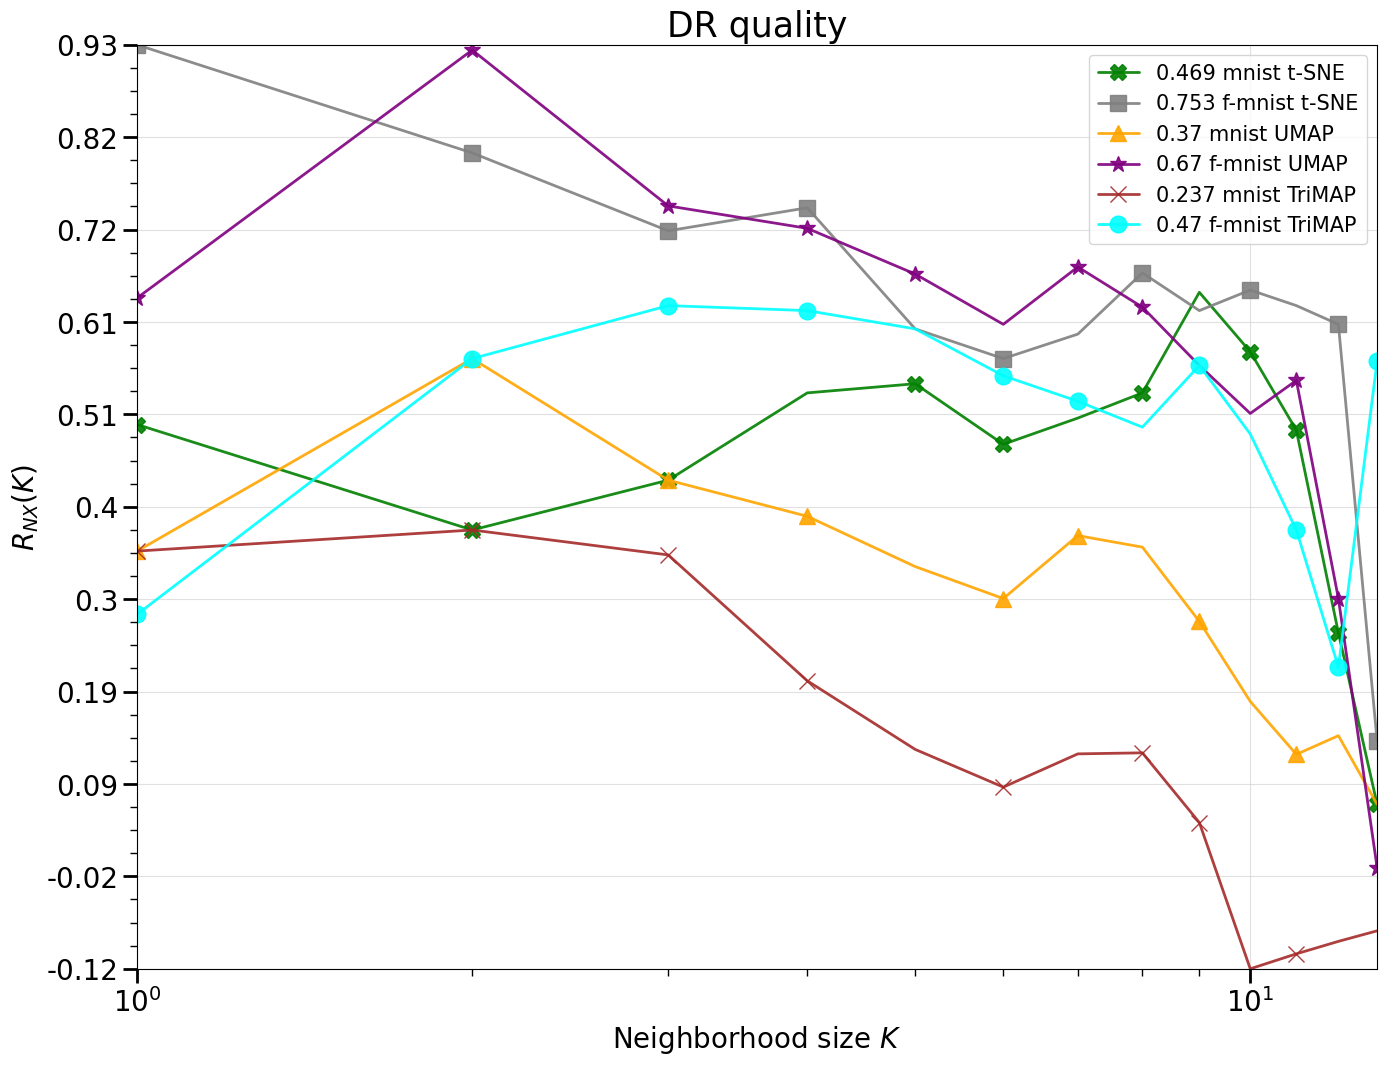

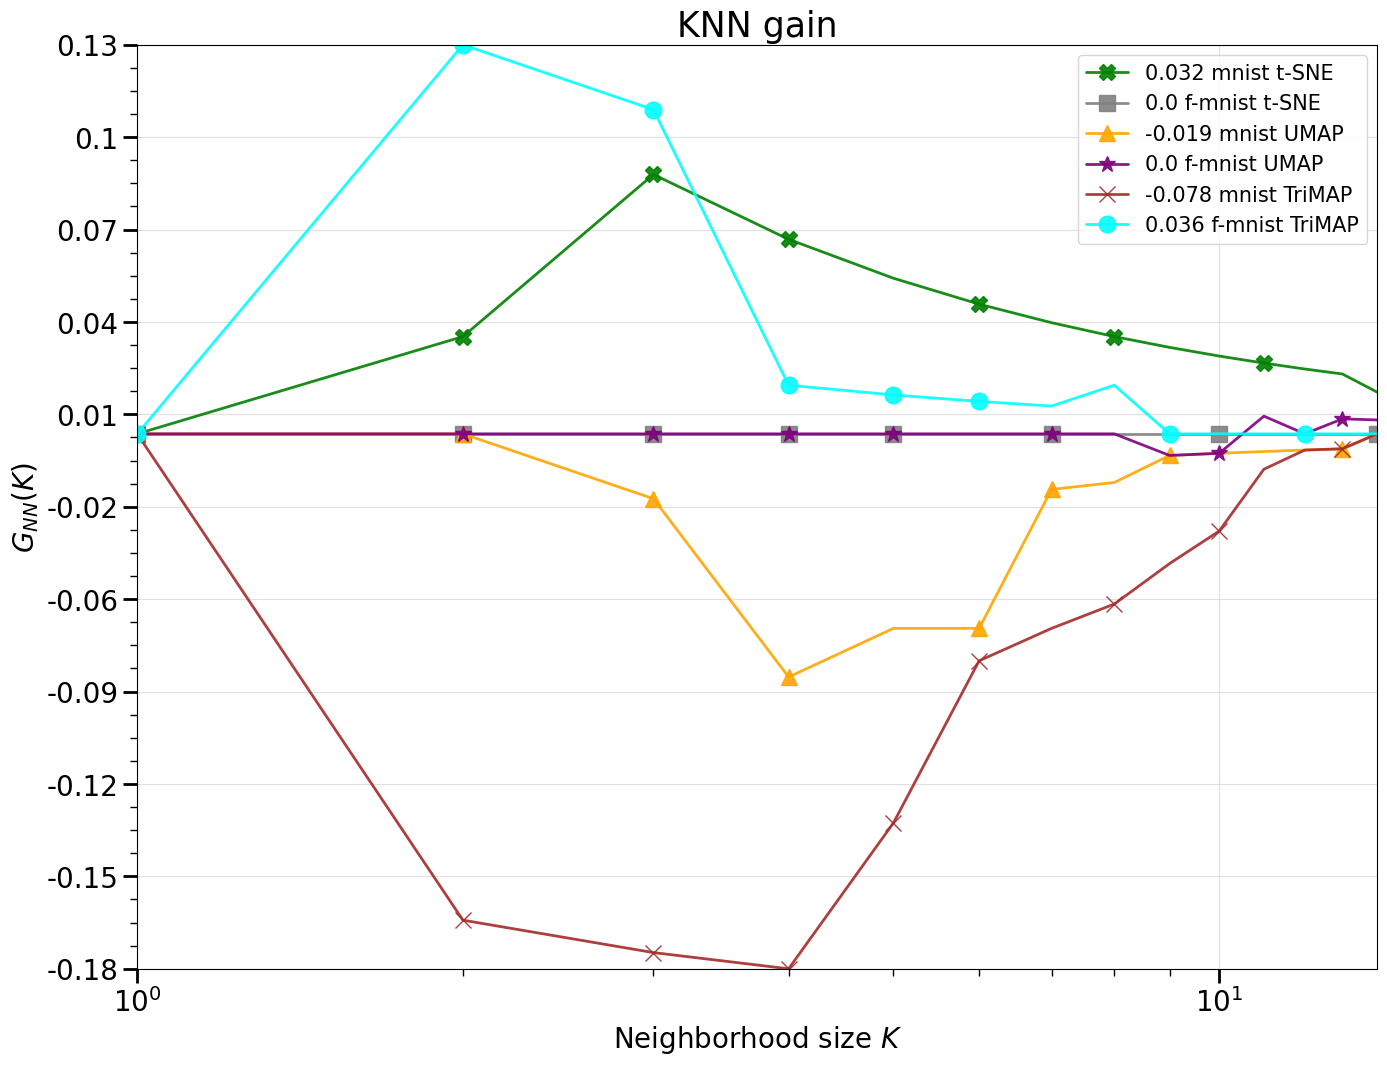

In [51]:
localMetric.visualize()

## Part 5: Analysis and Report

Write a comprehensive analysis (500-750 words) that addresses:

1. Which dimensionality reduction method best separates the classes in each dataset?
2. How do the optimal parameters differ between MNIST and Fashion MNIST?
3. Are certain classes consistently easier or harder to separate?
4. How do the quantitative metrics correlate with visual quality?
5. What are the trade-offs between the different methods in terms of:

- Computational efficiency
- Class separation
- Global structure preservation
- Sensitivity to hyperparameters


Based on both quantitative and qualitative evaluations, **t-SNE** consistently emerged as the best dimensionality reduction method for **both MNIST and Fashion-MNIST** datasets. <br>
It achieved the highest class fidelity scores and offered the most visually distinct separation between classes. <br>
**UMAP** followed closely, providing competitive performance with slightly less clear class boundaries, <br>
while **TriMAP** performed significantly worse, with lower fidelity scores and visual representations that often showed overlapping or poorly formed clusters. <br>

The optimal parameters remained consistent across both datasets for each method. For t-SNE, the best performance was observed with **perplexity=30**, **early_exaggeration=7**, and **max_iter=1000**, <br>
a configuration that effectively balanced local and global structure preservation. <br>
UMAP performed best with **n_neighbors=15** and **min_dist=0.5**, yielding well-separated clusters while still maintaining global relationships. <br>
TriMAP, using **n_inliers=20** and **n_outliers=10**, consistently failed to create clear visual or structural separation between classes, especially compared to the other methods.<br>

Certain classes were clearly harder to separate than others. In the MNIST dataset, digits **4, 7, and 9** often appeared confused and clustered closely, likely due to their similar shapes and shared features. <br>
In the Fashion-MNIST dataset, clothing items such as **T-shirt/top, Dress, Pullover, Shirt, and Coat** were frequently mixed, reflecting real-world similarity in their visual representations. <br>
On the other hand, digits like **0** or clothing items like **Sneakers**, **Sandals** and **Ankle boots** were more distinct and formed tighter, more isolated clusters.

There was a strong correlation between **quantitative metrics** such as class fidelity and **visual assessments**. <br>
Methods that scored higher on class fidelity (e.g., t-SNE and UMAP) also produced embeddings where classes were better separated and clusters were visually more compact and distinct. <br>
This alignment confirms that the cf metric is a reliable quantitative proxy for the intuitive quality of the embeddings.

Each method comes with trade-offs. **t-SNE** excels at class separation but is **computationally expensive** and **sensitive to hyperparameter tuning** (especially perplexity and early exaggeration). <br>
Its stochastic nature can also lead to variability between runs. **UMAP**, while slightly behind in class separation, is significantly **faster**, more scalable to larger datasets, and more **robust to parameter changes**, <br>
making it a strong practical choice. It also does a better job of preserving **global structure**, which t-SNE often distorts. **TriMAP**, designed for global structure preservation, <br>
sacrifices both local fidelity and clear class separation, which makes it less suitable for tasks focused on cluster interpretation or classification.

In summary, **t-SNE is ideal for precise, cluster-focused analysis**, **UMAP offers a solid balance between quality and efficiency**, and **TriMAP falls short** in tasks requiring clear class separation.
